In [ ]:
from functools import partial
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as v2
from torch.utils.data import random_split, DataLoader
from ray import tune, train
import tempfile
import torchDatasets as ds
from ray.train import Checkpoint
from ray.tune.schedulers import ASHAScheduler
# from torchvision.models import resnet50, resnet18
import networks as custNN
import matplotlib.pyplot as plt

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

modelName = "Autoencoder"; side = 10
base_dir = '/home/shashank/Code/gonihedric/'; dataDir = base_dir + "data/"
trainScheme = "Autoencoder"
criterion = nn.MSELoss()

# class ConvAutoencoder(nn.Module):
#     def __init__(self, latent_dim=8, dropout=0.2, internal_activaton=nn.ReLU(), output_activation=nn.Sigmoid()):
#         super(ConvAutoencoder, self).__init__()

#         self.drpt = nn.Dropout(dropout)

#         # ----- Encoder -----
#         self.encoder = nn.Sequential(
#             nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # -> (32, H/2, W/2)
#             # nn.BatchNorm2d(32),
#             internal_activaton,

#             # nn.Dropout(dropout),
#             nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # -> (64, H/4, W/4)
#             # nn.BatchNorm2d(64),
#             internal_activaton,

#             # nn.Dropout(dropout),
#             nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),# -> (128, H/8, W/8)
#             # nn.BatchNorm2d(128),
#             internal_activaton,
#         )

#         # Bottleneck (latent space)
#         self.fc_enc = nn.Linear(128 * 4 * 4, latent_dim)   # assumes input = 32x32
#         self.fc_dec = nn.Linear(latent_dim, 128 * 4 * 4)

#         # ----- Decoder -----
#         self.decoder = nn.Sequential(
#             # nn.Dropout(dropout),
#             nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # -> (64, H/4, W/4)
#             # nn.BatchNorm2d(64),
#             internal_activaton,

#             # nn.Dropout(dropout),
#             nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # -> (32, H/2, W/2)
#             # nn.BatchNorm2d(32),
#             internal_activaton,

#             # nn.Dropout(dropout),
#             nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> (1, H, W)
#             output_activation
#         )

#     def forward(self, x):
#         # Encode
#         x = self.encoder(x)
#         x = x.view(x.size(0), -1)      # flatten for FC
#         x = self.drpt(x)
#         z = self.fc_enc(x)

#         # Decode
#         z = self.drpt(z)
#         x = self.fc_dec(z)
#         x = x.view(x.size(0), 128, 4, 4)  # reshape back
#         x = self.decoder(x)
#         return x

class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=8, dropout=0.2):
        super(ConvAutoencoder, self).__init__()

        self.drpt = nn.Dropout(dropout)

        # ----- Encoder -----
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, padding_mode='circular'),  # -> (32, H/2, W/2)
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.Dropout(dropout),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # -> (64, H/4, W/4)
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Dropout(dropout),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),# -> (128, H/8, W/8)
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        )

        # Bottleneck (latent space)
        self.fc_enc = nn.Linear(128 * 4 * 4, latent_dim)   # assumes input = 32x32
        self.fc_dec = nn.Linear(latent_dim, 128 * 4 * 4)

        # ----- Decoder -----
        self.decoder = nn.Sequential(
            nn.Dropout(dropout),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # -> (64, H/4, W/4)
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Dropout(dropout),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # -> (32, H/2, W/2)
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.Dropout(dropout),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> (1, H, W)
            nn.Sigmoid()  # keeps output in [0,1] for binary images
        )

    def forward(self, x):
        # Encode
        x = self.encoder(x)
        x = x.view(x.size(0), -1)      # flatten for FC
        x = self.drpt(x)
        z = self.fc_enc(x)
        z = F.sigmoid(z)
        # Decode
        z = self.drpt(z)
        x = self.fc_dec(z)
        x = x.view(x.size(0), 128, 4, 4)  # reshape back
        x = self.decoder(x)
        return x


class ReshapeTransform:
    def __init__(self, shape):
        self.shape = shape
    def __call__(self, x):
        return x.view(*self.shape)

def load_data(data_dir, config):
    # model, transform = custNN.modelPicker(modelName, side, nTargets, data_dir)
    #paper = [900, 750, 600, 450, 300, 150, 75, 30, 10, 2]
    # model = custNN.Autoencoder([900, 750, 600, 450, 300, 150, 75, 30, config["latentSpace"]], nn.Sigmoid(), nn.Sigmoid())
    model = custNN.Autoencoder([1000, 750, 600, 450, 300, 150, 75, 30, 2], nn.Tanh(), nn.Tanh(), F.tanh)
    # model = custNN.Autoencoder([1024, 200, 50, 10], nn.Tanh(), nn.Tanh())
    # model = custNN.Autoencoder([1024, 300, 30, 2], nn.ReLU(), nn.Sigmoid(), F.sigmoid)
    # # model = AutoencoderCNN(2)
    # model = ConvAutoencoder(config["latentSpace"],0.2)
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    else:
        model = model.to(device)
    
    # transform =  None
    transform = v2.Compose([v2.Lambda(lambda x: 2*x - 1)])#
    # transform = v2.RandomVerticalFlip()
    # transform = v2.Compose([v2.RandomHorizontalFlip(),
    #                         v2.RandomVerticalFlip(),
    #                         ReshapeTransform((1,side,side))])# None 
    trainset = ds.CustomAutoencoderDataset3D(data_dir+"trainG3D", side, transform) # 2DGH32 gnhd2dTest
    testset = ds.CustomAutoencoderDataset3D(data_dir+"testG3D", side, transform) # 2DGH32 gnhd2dTrain
    return model, trainset, testset

def initialize_weights(model):
    nn.init.normal_(model.conv1.weight, 0, 0.1)
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.1)
            nn.init.constant_(m.bias, 0)


def trainFN(config):

    net, trainset, _ = load_data(dataDir, config)
    custNN.initialize_weights(net)
    
    # optimizer = optim.SGD(net.parameters(),lr=config["lr"],
    #                       momentum=config["momentum"],weight_decay=config["wd"])
    # optimizer = optim.Adam(net.parameters(),lr=config["lr"],weight_decay = config["wd"])

    optimizer = optim.Adam(net.parameters(),lr=config["lr"],weight_decay = config["wd"])
    # optimizer = optim.Adadelta(net.parameters(), lr=config["lr"], weight_decay=config["wd"])

    exp_lr_scheduler = None# optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=config["gamma"])

    # Load existing checkpoint through `get_checkpoint()` API.
    if train.get_checkpoint():
        loaded_checkpoint = train.get_checkpoint()
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
            model_state, optimizer_state = torch.load(
                os.path.join(loaded_checkpoint_dir, "checkpoint.pt")
            )
            net.load_state_dict(model_state)
            optimizer.load_state_dict(optimizer_state)

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    trainloader = DataLoader( train_subset,
                             batch_size=config["batch_size"],
                             shuffle=True,
                             num_workers=4)
    valloader = DataLoader( val_subset,
                           batch_size=128,
                           shuffle=True,
                           num_workers=4)
    # contractive_loss = lambda enc, imag : torch.norm(torch.autograd.functional.jacobian(enc, imag, create_graph=True))
    for epoch in range(50):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        net.train(); i = 0
        for inputs,_ in trainloader:
            # get the inputs; data is a list of [inputs, labels]
            inputs = inputs.to(device)

            optimizer.zero_grad() # zero the parameter gradients
            # forward + backward + optimize
            outputs = net(inputs).squeeze()
            # outputs = outputs.float(); labels = labels.float()
            loss = criterion(outputs, inputs.squeeze()) #+ config["lam"] * contractive_loss(net.encoder, inputs)
            # loss = criterion(outputs, inputs.squeeze()) + config.get("lam", 0.0)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print(
                    "[%d, %5d] loss: %.3f"
                    % (epoch + 1, i + 1, running_loss / epoch_steps)
                )
                epoch_steps = 0
                running_loss = 0.0
                if exp_lr_scheduler is not None:
                    exp_lr_scheduler.step()
            i += 1

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        # correct = 0
        net.eval()
        with torch.no_grad():
            for inputs,_ in valloader:
                inputs = inputs.to(device)
                outputs = net(inputs)
                outputs = outputs.detach().squeeze().float()
                val_loss += criterion(outputs, inputs.squeeze()).cpu().numpy()
                # predicted = torch.max(F.softmax(outputs, dim=1), 1).indices
                # correct += (predicted == labels.max(1).indices).sum().div(torch.numel(predicted)).item()
                val_steps += 1

# Here we save a checkpoint. It is automatically registered with
        # Ray Tune and will potentially be accessed through in ``get_checkpoint()``
        # in future iterations.
        # Note to save a file like checkpoint, you still need to put it under a directory
        # to construct a checkpoint.
        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            path = os.path.join(temp_checkpoint_dir, "checkpoint.pt")
            torch.save(
                (net.state_dict(), optimizer.state_dict()), path
            )
            checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)
            train.report(
                {"loss": (val_loss / val_steps), 
                #  "accuracy": (correct / val_steps)
                 },
                checkpoint=checkpoint,
            )
    print("Finished Training")

def test_best_model(best_result):
    best_trained_model, _, testset = load_data(dataDir, best_result.config)

    checkpoint_path = os.path.join(best_result.checkpoint.to_directory(), "checkpoint.pt")

    model_state, _ = torch.load(checkpoint_path)
    best_trained_model.load_state_dict(model_state)

    testloader = DataLoader( testset, batch_size=128, 
                            shuffle=False, num_workers=4)

    correct = 0; total = 0; loss = 0
    best_trained_model.eval()
    with torch.no_grad():
        for inputs,_ in testloader:
            inputs = inputs.to(device)
            outputs = best_trained_model(inputs)
            outputs = outputs.detach().squeeze().float()
            loss += criterion(outputs, inputs.squeeze()).cpu().numpy()
            total += 1
    # print("Best trial test set accuracy for \"{}\": {}".format(trainScheme, correct/total))
    print("Best trial test set loss for \"{}\": {}".format(trainScheme, loss/total))

def main(num_samples=10, max_num_epochs=10, cpus_per_trial=6, gpus_per_trial=2):
    config = {
    "lr": tune.loguniform(5e-2, 5e-5),
    # "latentSpace": tune.choice([2, 4, 8, 16]),
    "batch_size": tune.choice([64, 128, 256]),
    "wd": tune.loguniform(1e-1, 1e-5),
    # "activation": tune.choice([F.relu, F.sigmoid, F.tanh]),
    # "lam": tune.loguniform(1e-1, 1e-5),
    # "momentum": tune.uniform(0.1, 1.0),
    # "amsgrad": tune.choice([True, False]),
    # "dropout": tune.uniform(0.0, 0.5),
    }
    print(modelName + " with SGD for OP side:"+str(side))
    scheduler = ASHAScheduler(
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2
    )
    tuner = tune.Tuner(
         tune.with_resources(
            tune.with_parameters(trainFN),
            resources={"cpu": cpus_per_trial, "gpu": gpus_per_trial}
        ),
        tune_config=tune.TuneConfig(
            metric="loss",
            mode="min",
            scheduler=scheduler,
            num_samples=num_samples,
        ),
        param_space=config,
    )
    results = tuner.fit()
    best_result = results.get_best_result("loss", "min")

    print("Best trial config: {}".format(best_result.config))
    print("Best trial final validation loss: {}".format(
        best_result.metrics["loss"]))
    # if nTargets > 1:
    #     print("Best trial final validation accuracy: {}".format(
    #         best_result.metrics["accuracy"]))
    test_best_model(best_result)

In [14]:
main(num_samples=20, max_num_epochs=100, gpus_per_trial=1)

2025-11-11 12:00:32,862	WARNING util.py:201 -- The `on_step_begin` operation took 0.608 s, which may be a performance bottleneck.
2025-11-11 12:02:29,261	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/shashank/ray_results/trainFN_2025-11-11_11-59-11' in 0.0114s.
2025-11-11 12:02:29,265	INFO tune.py:1041 -- Total run time: 197.30 seconds (197.27 seconds for the tuning loop).


Best trial config: {'lr': 0.0006663077232989761, 'batch_size': 64}
Best trial final validation loss: 0.9839603304862976
Best trial test set loss for "Autoencoder": 0.9820035099983215


In [ ]:
main(num_samples=20, max_num_epochs=100, gpus_per_trial=1)

2025-10-23 09:42:33,234	ERROR tune_controller.py:1331 -- Trial task failed for trial trainFN_d46d4_00000
Traceback (most recent call last):
  File "/home/shashank/miniconda3/envs/neuralnets/lib/python3.11/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/home/shashank/miniconda3/envs/neuralnets/lib/python3.11/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/shashank/miniconda3/envs/neuralnets/lib/python3.11/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/shashank/miniconda3/envs/neuralnets/lib/python3.11/site-packages/ray/_private/worker.py", line 2753, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^

RuntimeError: No best trial found for the given metric: loss. This means that no trial has reported this metric, or all values reported for this metric are NaN. To not ignore NaN values, you can set the `filter_nan_and_inf` arg to False.

In [19]:
main(num_samples=20, max_num_epochs=100, gpus_per_trial=1)

2025-10-06 11:02:08,768	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/shashank/ray_results/trainFN_2025-10-06_10-59-59' in 0.0050s.
2025-10-06 11:02:08,772	INFO tune.py:1041 -- Total run time: 129.47 seconds (129.45 seconds for the tuning loop).


Best trial config: {'lr': 0.007519875551227198, 'latentSpace': 8, 'wd': 0.0011214449822134858}
Best trial final validation loss: 0.40943703055381775
Best trial test set loss for "Autoencoder": 0.38199755549430847


In [36]:
model = ConvAutoencoder(8).to(device)
# model = custNN.Autoencoder([900, 750, 600, 450, 300, 150, 75, 30, 10, 2], nn.Tanh(), nn.Tanh())
# model.load_state_dict(torch.load(data_dir+f"checkpoints/Autoencoder/"+date+"/2/model_epoch_60.pth", map_location=device))
# model.load_state_dict(torch.load(data_dir+f"checkpoints/Autoencoder/model.pth", map_location=device))

side = 32
class ReshapeTransform:
    def __init__(self, shape):
        self.shape = shape
    def __call__(self, x):
        return x.view(*self.shape)

def visualize_reconstruction(model, data_loader, side=30):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(data_loader))
        images = images.to(device)
        reconstructed = model(images)

        # Plot original vs reconstructed images
        fig, axes = plt.subplots(2, 8, figsize=(15, 4))
        for i in range(8):
            # Original images
            axes[0,i].imshow(images[i].cpu().numpy().squeeze().reshape(side, side), cmap='gray')
            axes[0,i].axis('off')

            # Reconstructed images
            axes[1,i].imshow(reconstructed[i].cpu().numpy().squeeze().reshape(side, side), cmap='gray')
            axes[1,i].axis('off')

        plt.tight_layout()
        plt.show()
        


transform = ReshapeTransform((1, side, side)) # v2.Compose([v2.Lambda(lambda x: 2*x - 1)]) # None #
trainset = ds.CustomAutoencoderDataset(dataDir+"testPUD", side, transform)
data_loader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)

visualize_reconstruction(model, data_loader, side)
# visualize_reconstruction(model,  smallTrainLoader)

    

RuntimeError: running_mean should contain 16 elements not 64

In [1]:
from utilsTrainTest import visualize_reconstruction
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torchDatasets as ds
import matplotlib.pyplot as plt
import torch as T
side = 10
side1 = 40
side2 = 25

class ConvAutoencoder(nn.Module):
    def __init__(self, dropout=0.2):
        super(ConvAutoencoder, self).__init__()

        # ----- Encoder -----
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, stride=2, padding=1),  # -> (16, H/2, W/2)
            nn.BatchNorm3d(16),
            nn.ReLU(True),

            nn.Dropout(dropout),
            nn.Conv3d(16, 24, kernel_size=3, stride=2, padding=1), # -> (24, H/4, W/4)
            nn.BatchNorm3d(24),
            nn.ReLU(True)
        )

        # ----- Decoder -----
        self.decoder = nn.Sequential(
            nn.Dropout(dropout),
            nn.ConvTranspose3d(24, 40, kernel_size=3, stride=2, padding=1, output_padding=1), # -> (40, H/4, W/4)
            nn.BatchNorm3d(40),
            nn.ReLU(True),

            nn.Dropout(dropout),
            nn.ConvTranspose3d(40, 48, kernel_size=3, stride=2, padding=1, output_padding=1), # -> (48, H/2, W/2)
            nn.BatchNorm3d(48),
            nn.ReLU(True),

            nn.Dropout(dropout),
            nn.Conv3d(48, 1, kernel_size=3, stride=1, padding=0),  # -> (1, H, W)
            nn.Sigmoid()  # keeps output in [0,1] for binary images
        )

    def forward(self, x):
        # Encode
        x = self.encoder(x)
        x = self.decoder(x)
        return x
model = ConvAutoencoder(0.2)
device = "cpu"
if T.cuda.is_available():
    device = "cuda"
model.load_state_dict(T.load("/home/shashank/Code/gonihedric/data/ghData/checkpoints/Autoencoder/2026-01-13_21-06-13/1/best_model.pth", map_location=device))
model = model.to(device)
model.eval()
batchSize = 100
dataDir = '/home/shashank/Code/gonihedric/data/ghData/'

In [ ]:
testLossesMean = np.empty([11, 21])
testLossesStd = np.empty([11, 21])
batchSize = 1000
for k_idx, k in enumerate(np.arange(0.0, 1.1, 0.1)):
    dataset = ds.CustomAutoencoderDataset3D(dataDir+"testL10k"+"{:.2f}".format(k), side) #2DGH32
    testLoader = T.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=False)
    model.eval()
    j = 0
    tmpCount = np.zeros(21, dtype=int); tmpLosses = np.empty([21, 10000])
    with T.no_grad():
        for batch_idx, (images,label) in enumerate(testLoader):
            images = images.to(device)
            outputs = model(images)
            loss = F.mse_loss(outputs, images, reduction='none').mean((2,3,4)).squeeze().cpu().numpy()
            for i in range(len(loss)):
                tmpLosses[int(label.numpy()[i,0]*20), tmpCount[int(label.numpy()[i,0]*20)]] = loss[i]
                tmpCount[int(label.numpy()[i,0]*20)] += 1
    testLossesMean[k_idx,:] = np.mean(tmpLosses[:,:tmpCount.max()], axis=1)
    testLossesStd[k_idx,:] = np.std(tmpLosses[:,:tmpCount.max()], axis=1)


In [ ]:
np.savez_compressed(dataDir+"testL10kAutoencoderLosses.npz", testLosses=testLosses)
testLosses = np.load(dataDir+"testL10kAutoencoderLosses.npz")["testLosses"]

In [76]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']
plt.rcParams['figure.dpi']= 300

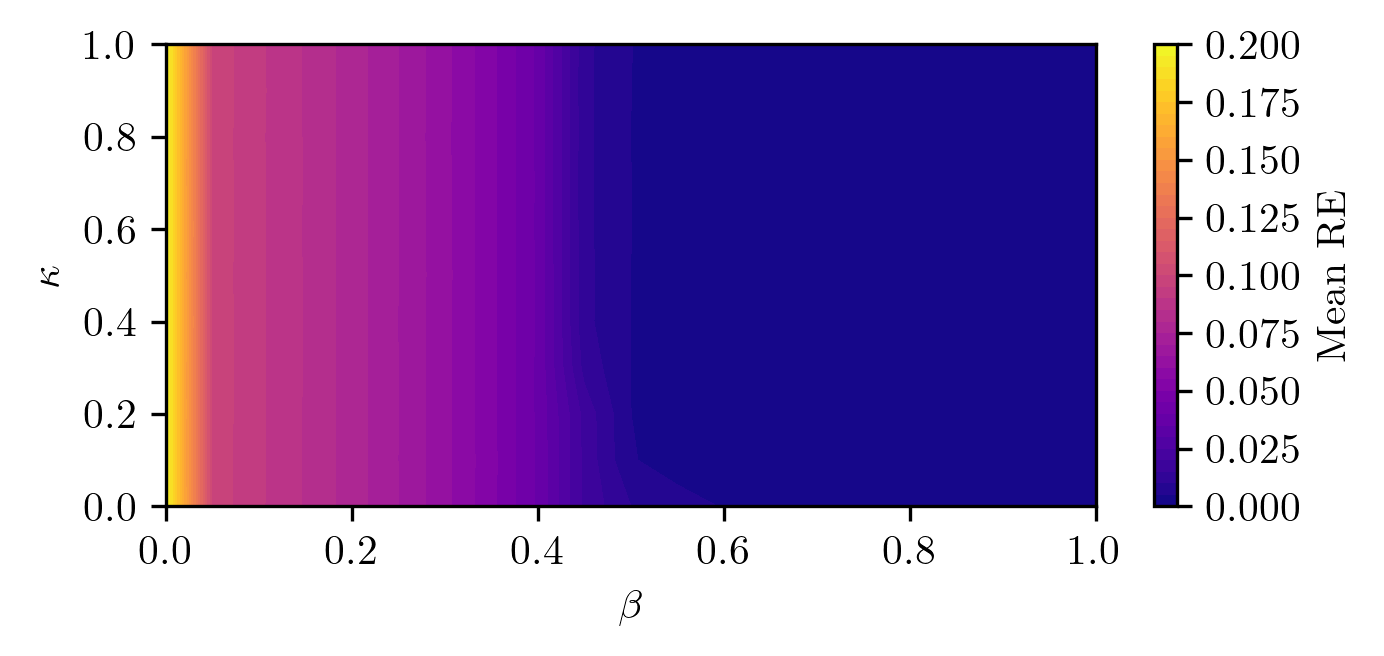

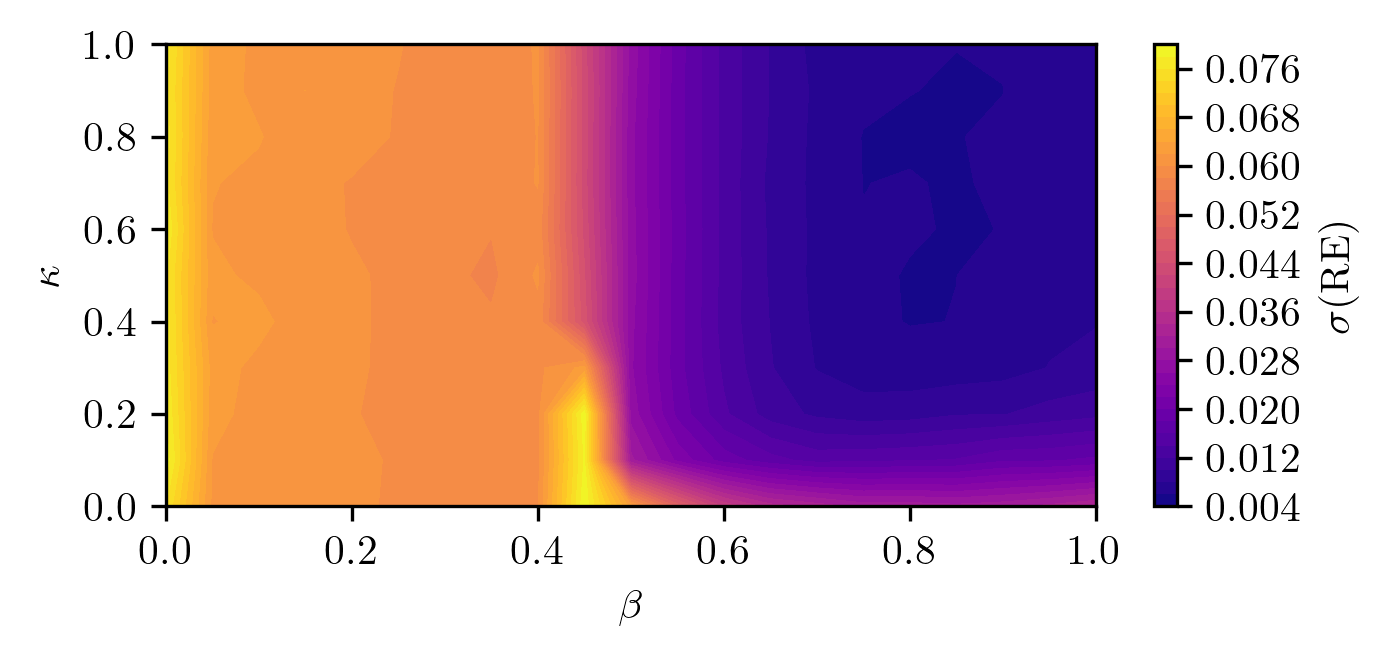

In [105]:
x = np.arange(0.0, 1.05, 0.05)
y = np.arange(0.0, 1.1, 0.1)
plt.contourf(x, y, testLossesMean, levels=40, cmap='plasma')
plt.colorbar(label='Mean RE')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\kappa$')
# plt.title('Autoencoder Reconstruction Error on Gonihedric Data')
plt.show()

plt.contourf(x, y, testLossesStd*10, levels=40, cmap='plasma')
plt.colorbar(label=r'$\sigma$(RE)')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\kappa$')
# plt.title('Autoencoder Reconstruction Error Std Dev on Gonihedric Data')
plt.show()

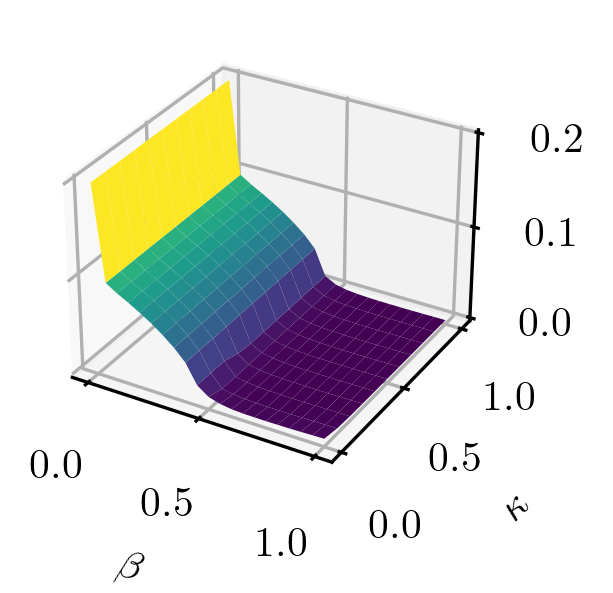

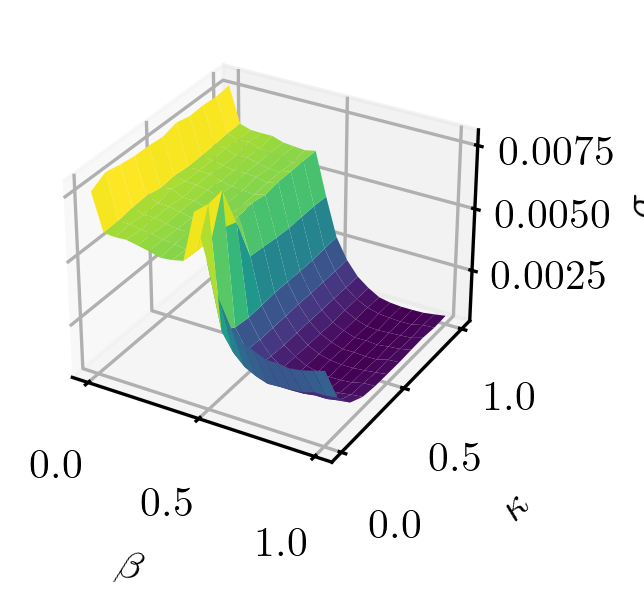

In [104]:
x = np.arange(0.0, 1.05, 0.05)
y = np.arange(0.0, 1.1, 0.1)
X, Y = np.meshgrid(x, y)
Z = testLossesMean
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
RE = ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'$\kappa$')
ax.set_zlabel('Mean RE')
# fig.colorbar(RE, label='Mean RE')
plt.show()

Z = testLossesStd
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sigma = ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'$\kappa$')
ax.set_zlabel(r'$\sigma$')
# fig.colorbar(sigma, label=r'$\sigma$')
plt.show()

Labels:  [0.  0.9]


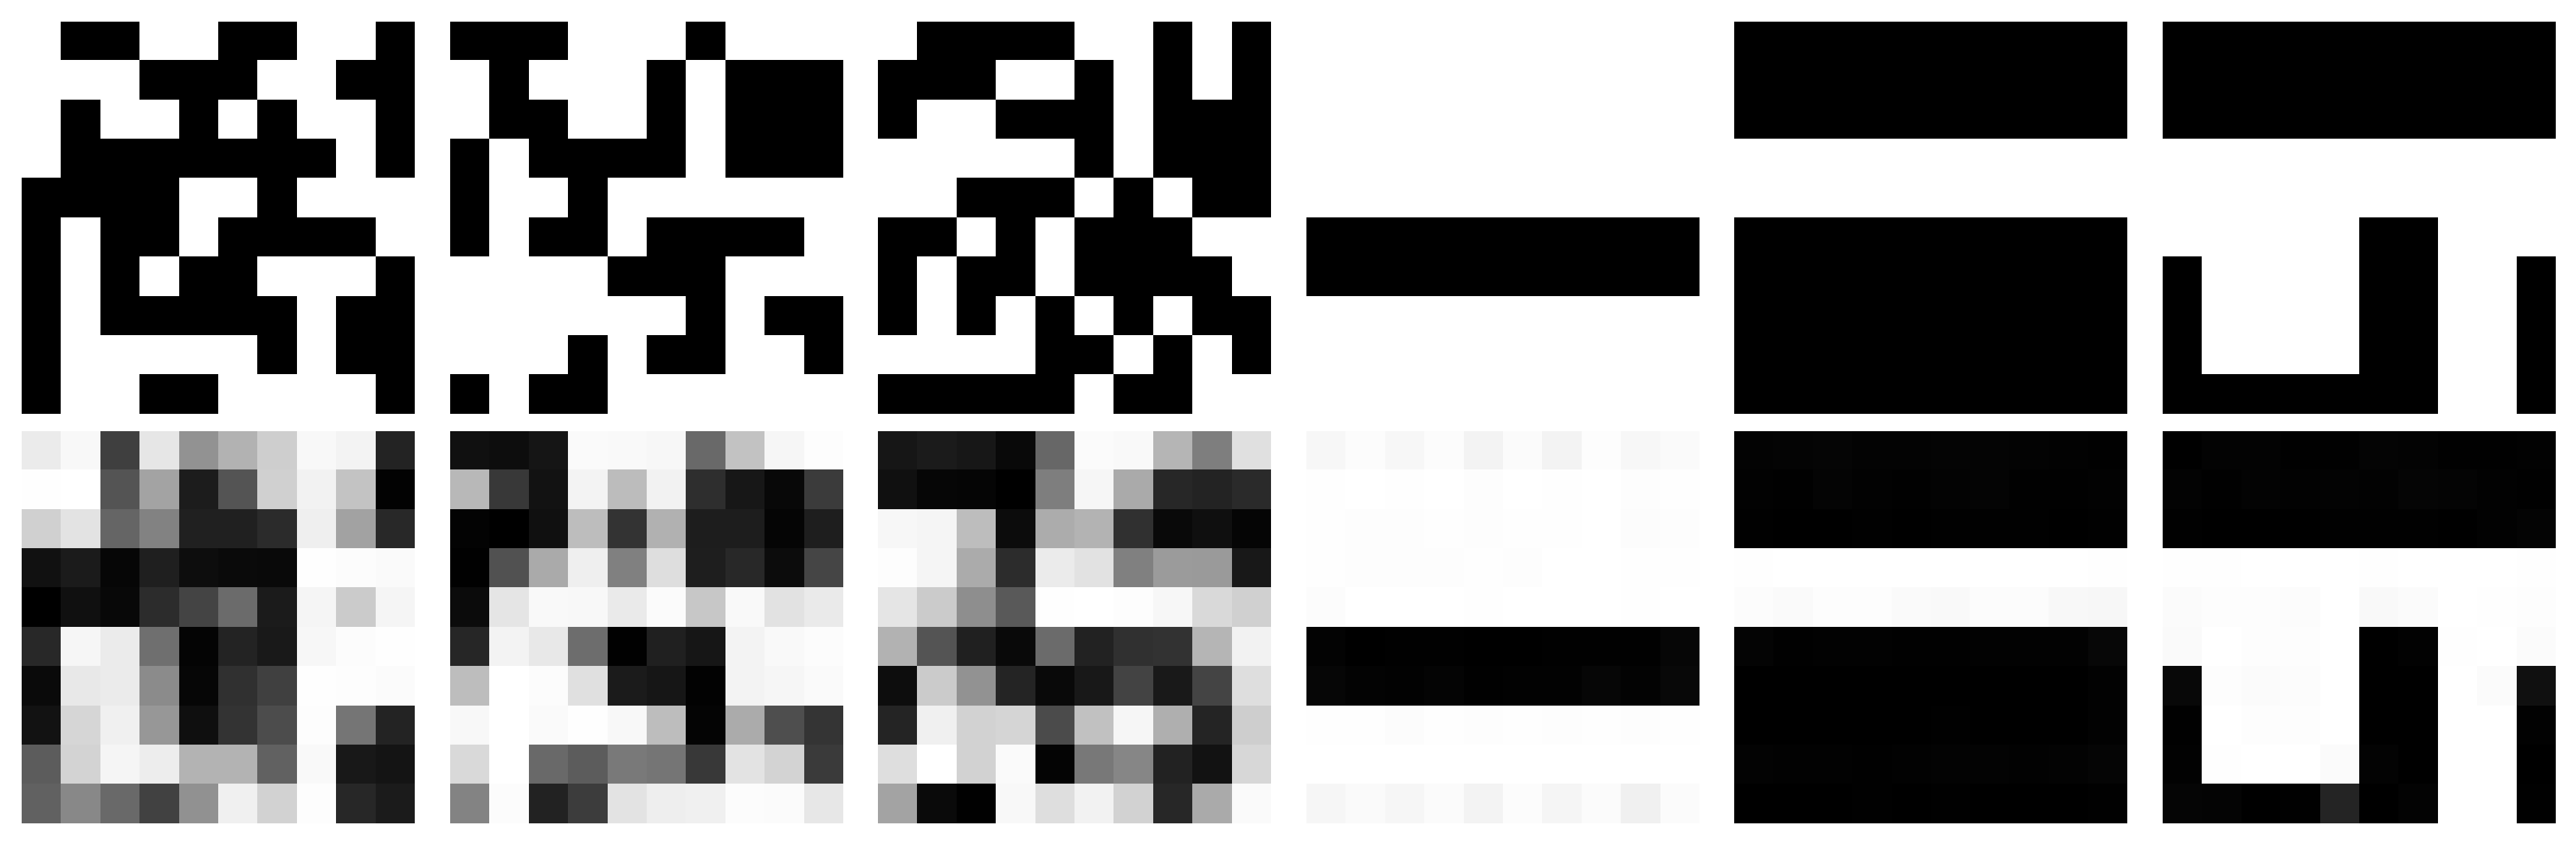

In [117]:
def visualize_reconstruction(model, device, data_loader, side, location="", name:str="reconstruction"):
    model.eval()
    with T.no_grad():
        (images,labels) = next(iter(data_loader))
        images = images.to(device)
        reconstructed = model(images)

        # Plot original vs reconstructed images
        fig, axes = plt.subplots(2, 6, figsize=(12, 4))
        for i in range(2):
            # Original images
            ogImg = images[i].cpu().numpy().squeeze().reshape(side, side, side)

            axes[0,i*3].imshow(ogImg[side//2,:,:], cmap='gray')
            axes[0,3*i].axis('off')

            axes[0,3*i+1].imshow(ogImg[:,side//2,:], cmap='gray')
            axes[0,3*i+1].axis('off')

            axes[0,3*i+2].imshow(ogImg[:,:,side//2], cmap='gray')
            axes[0,3*i+2].axis('off')

            # Reconstructed images
            recImg = reconstructed[i].cpu().numpy().squeeze().reshape(side, side, side)
            axes[1,3*i].imshow(recImg[side//2,:,:], cmap='gray')
            axes[1,3*i].axis('off')
            axes[1,3*i+1].imshow(recImg[:,side//2,:], cmap='gray')
            axes[1,3*i+1].axis('off')
            axes[1,3*i+2].imshow(recImg[:,:,side//2], cmap='gray')
            axes[1,3*i+2].axis('off')
        print("Labels: ", labels[:2].cpu().numpy().squeeze())
        plt.tight_layout()
        if location != "":
            plt.savefig(location+"/"+name+".png")
        else:
            plt.show()
        plt.close()

dataset = ds.CustomAutoencoderDataset3D(dataDir+"testL10k"+"{:.2f}".format(0.6), side) #2DGH32
testLoader = T.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)

visualize_reconstruction(model, device, testLoader, side)

In [1]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import torchDatasets as ds
import networks as custNN

sns.set_theme(style='whitegrid')

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']
plt.rcParams['figure.dpi']= 300

import torch as T

# Device configuration
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
side = 10

dataDir = '/home/shashank/Code/gonihedric/data/ghData/'

In [51]:
batchSize = 1000; kVals = np.arange(0.0, 1.1, 0.1)
configs = np.empty((batchSize*len(kVals), 1000)); params = np.empty((batchSize*len(kVals), 2))
for k_idx, k in enumerate(kVals):
    dataset = ds.CustomAutoencoderDataset3D(dataDir+"testL10k"+"{:.2f}".format(k), side)
    # dataset = ds.CustomAutoencoderDataset3D(dataDir+"testL10", side)
    testLoader = T.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=True)
    with T.no_grad():
        tempConfigs, tempParams = next(iter(testLoader))
        configs[batchSize*k_idx:batchSize*(k_idx+1),:] = tempConfigs.flatten(1,-1).numpy()
        params[batchSize*k_idx:batchSize*(k_idx+1),1] = k
        params[batchSize*k_idx:batchSize*(k_idx+1),0] = tempParams.squeeze().numpy()

In [50]:
batchSize = 1000;
dataset = ds.CustomAutoencoderDataset3D(dataDir+"testL10", side)
testLoader = T.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=True)
configs = np.empty((len(dataset), 1000)); params = np.empty((len(dataset), 2))
with T.no_grad():
    for idx, (tempConfigs, tempParams) in enumerate(testLoader):        
        length = tempConfigs.shape[0]
        configs[length*idx:length*(idx+1),:] = tempConfigs.flatten(1,-1).numpy()
        params[length*idx:length*(idx+1),1] = tempParams.squeeze().numpy()[:,1]
        params[length*idx:length*(idx+1),0] = tempParams.squeeze().numpy()[:,0]

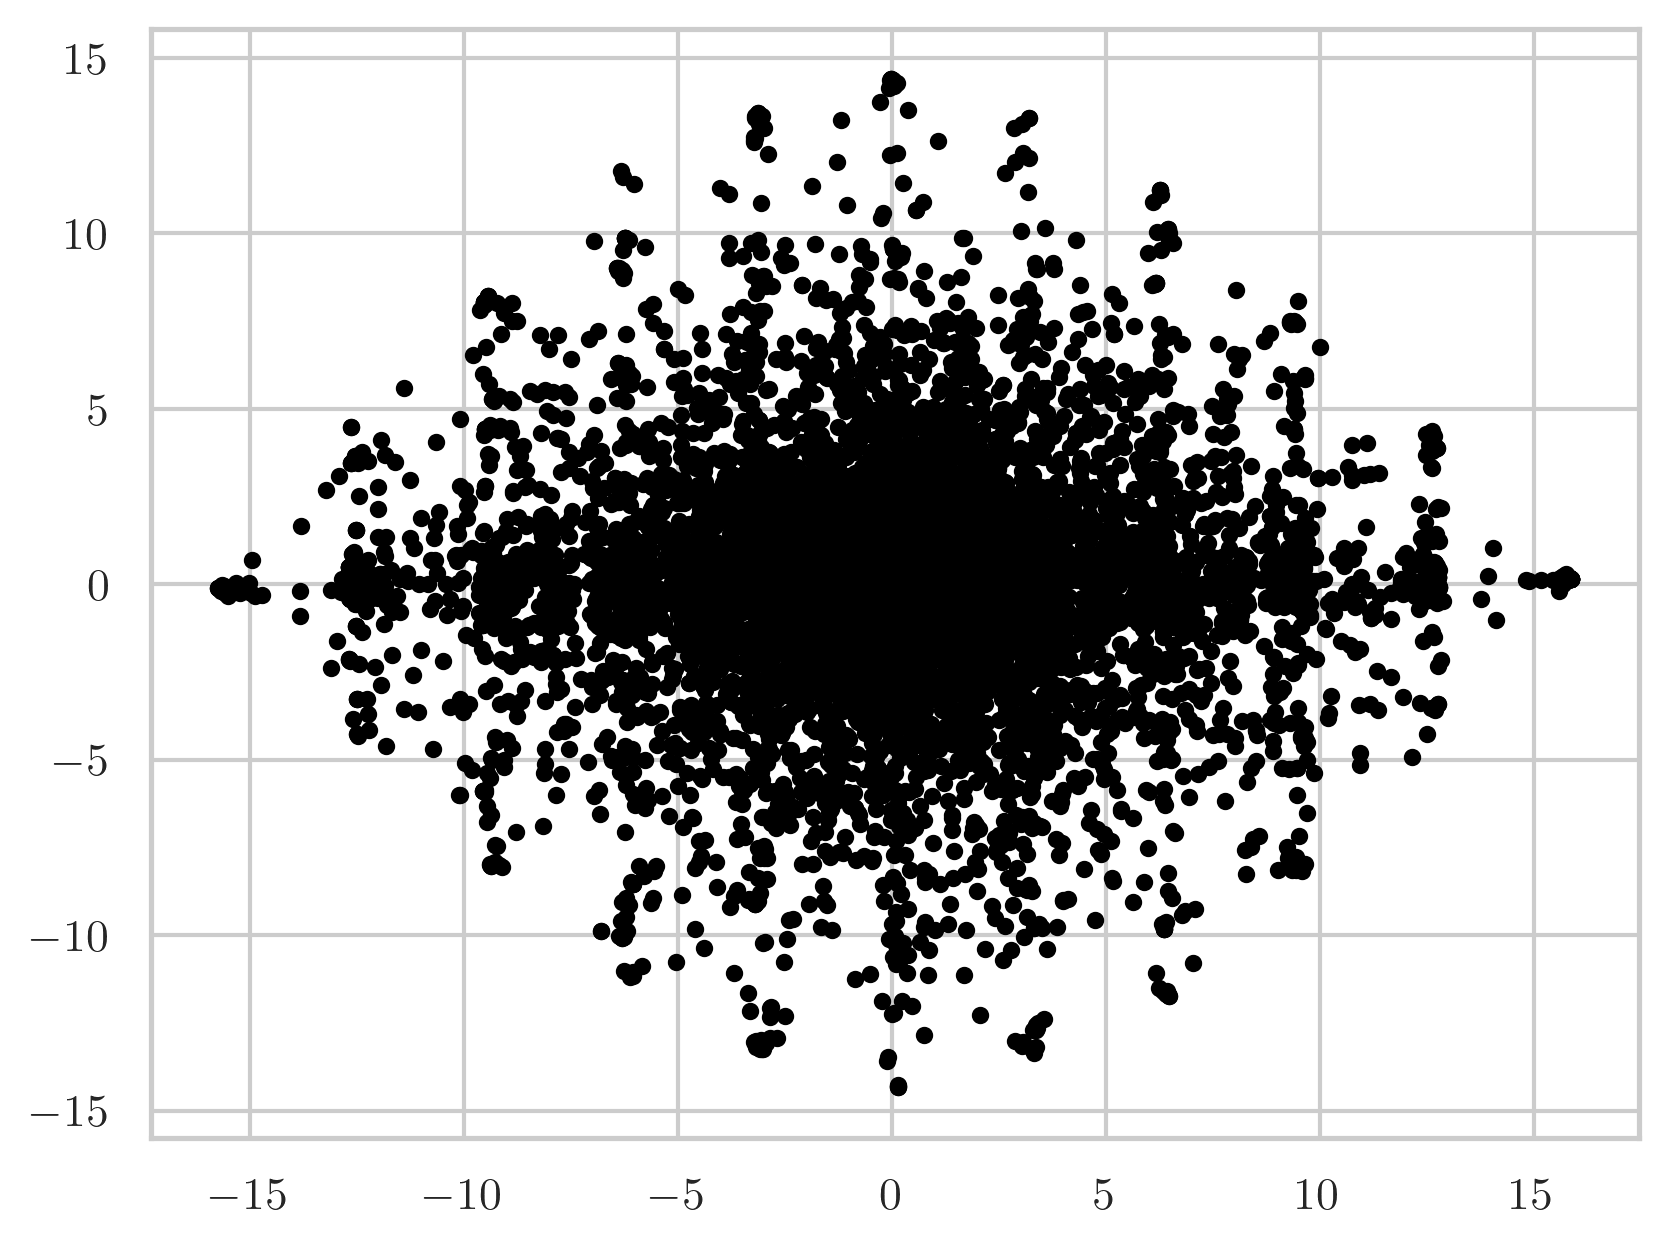

PCA components: (11000, 2)


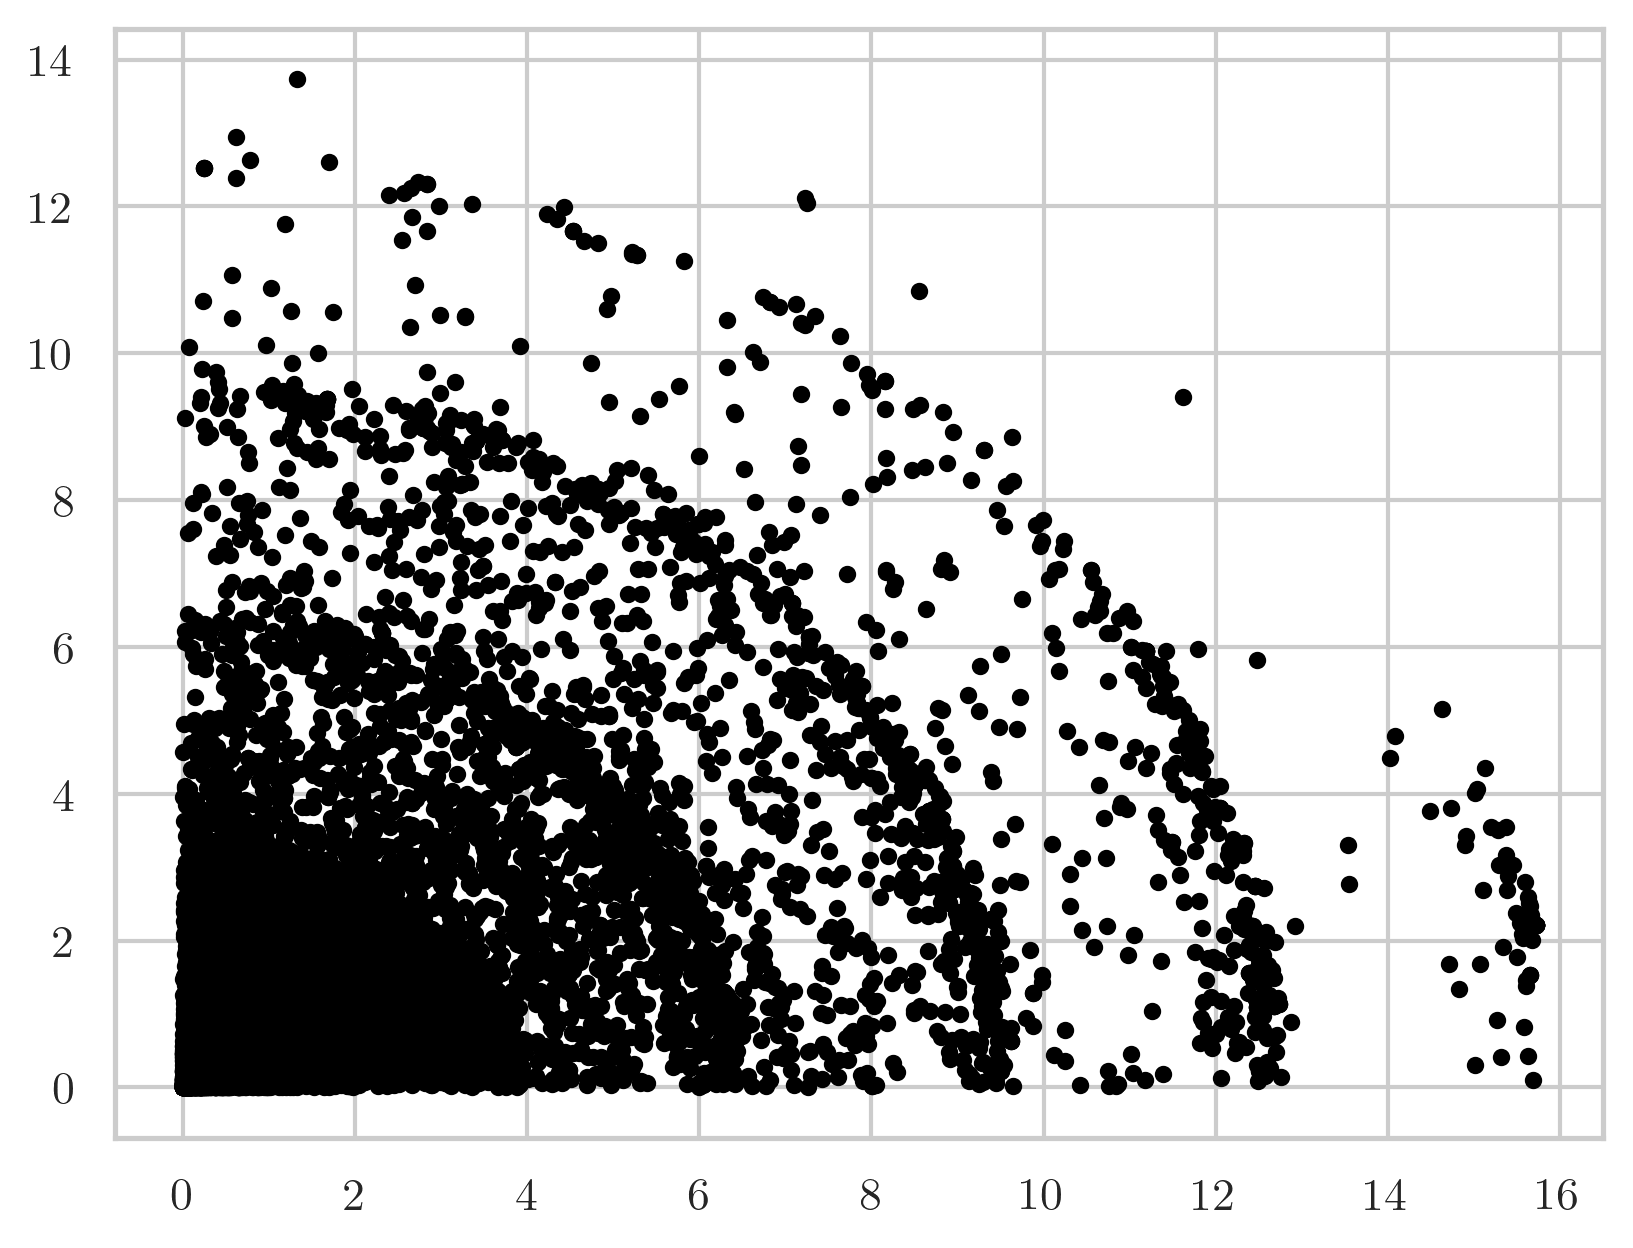

PCA components: (11000, 2)


In [52]:
pca = PCA(n_components=2)
pca_Raw = pca.fit_transform(configs.reshape(configs.shape[0], -1))

latent_vectors = pca_Raw

L1 = pca_Raw[:, 0]; L2 = pca_Raw[:, 1]
plt.scatter(L1, L2, s=10, c='black', label='PCA (NN)')
plt.show()
print("PCA components:", latent_vectors.shape)

# L1 = np.abs(latent_vectors[:, 0]); L2 = np.abs(latent_vectors[:, 1])
L1 = latent_vectors[:, 0]*np.cos(latent_vectors[:, 1]); L2 = latent_vectors[:, 0]*np.sin(latent_vectors[:, 1])
L1 = np.abs(L1); L2 = np.abs(L2)

plt.scatter(L1, L2, s=10, c='black', label='PCA (NN)')
plt.show()
print("PCA components:", latent_vectors.shape)




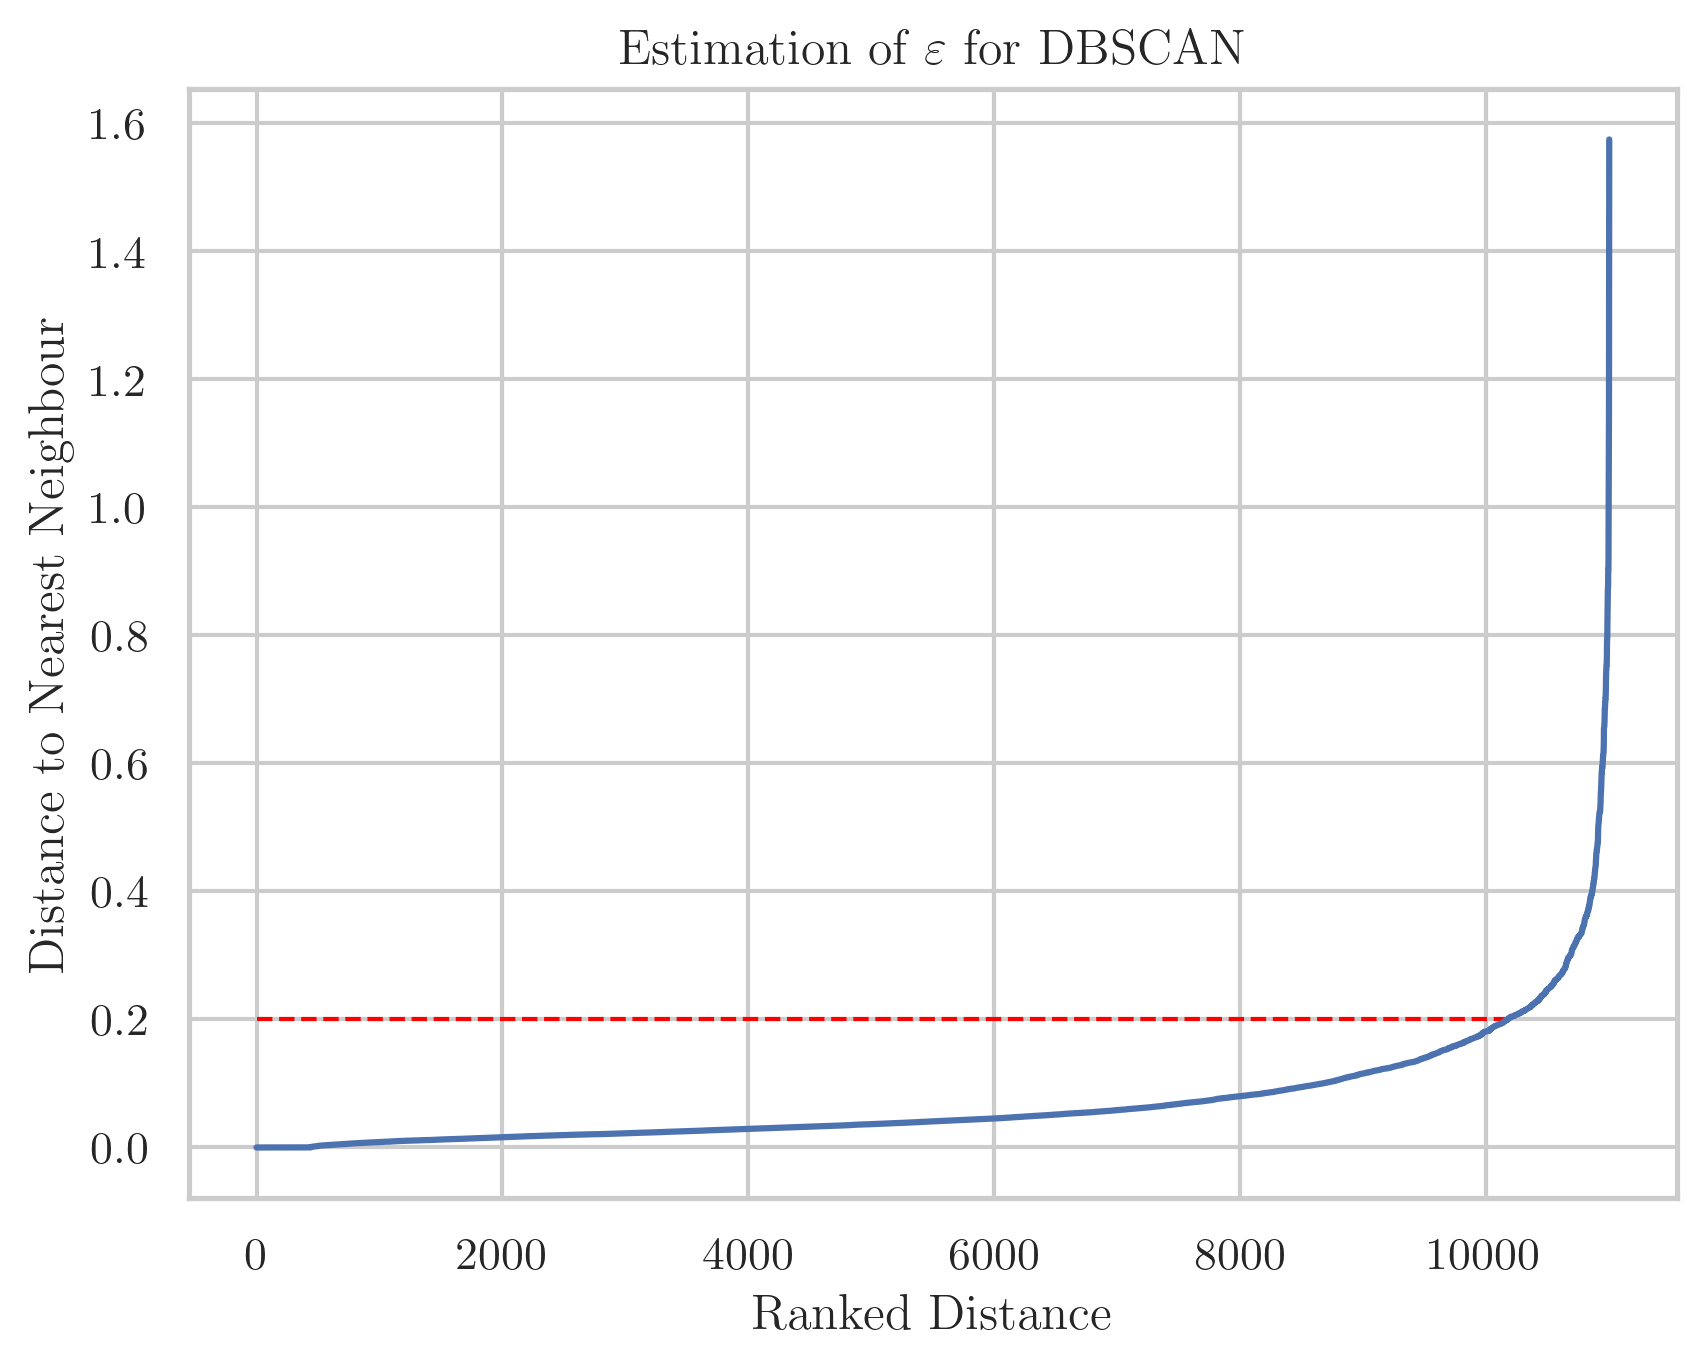

In [53]:

neighbours = NearestNeighbors(n_neighbors=10)
neighbours_fit2 = neighbours.fit(latent_vectors)
distances2,_ = neighbours_fit2.kneighbors(latent_vectors)
distances2 = np.sort(distances2, axis=0)
distances2 = distances2[:, 1]  # Exclude the first column (distance to itself)

epsilon = 0.2
min_samples = 20
dbscan2 = DBSCAN(eps=epsilon, min_samples=min_samples)
labels2 = dbscan2.fit_predict(latent_vectors)
plt.hlines(y=epsilon, xmin=0, xmax=np.max(np.where(distances2<epsilon)), color='red', linestyle='--', label=r'$\varepsilon$', linewidth=1)
plt.plot(distances2, label='Nearest Neighbours Distance')
plt.title(r'Estimation of $\varepsilon$ for DBSCAN')
plt.xlabel('Ranked Distance')
plt.ylabel('Distance to Nearest Neighbour')
# plt.ylim(0.0, 0.150)
# plt.xlim(3550, 4000)
plt.show()

20 clusters found


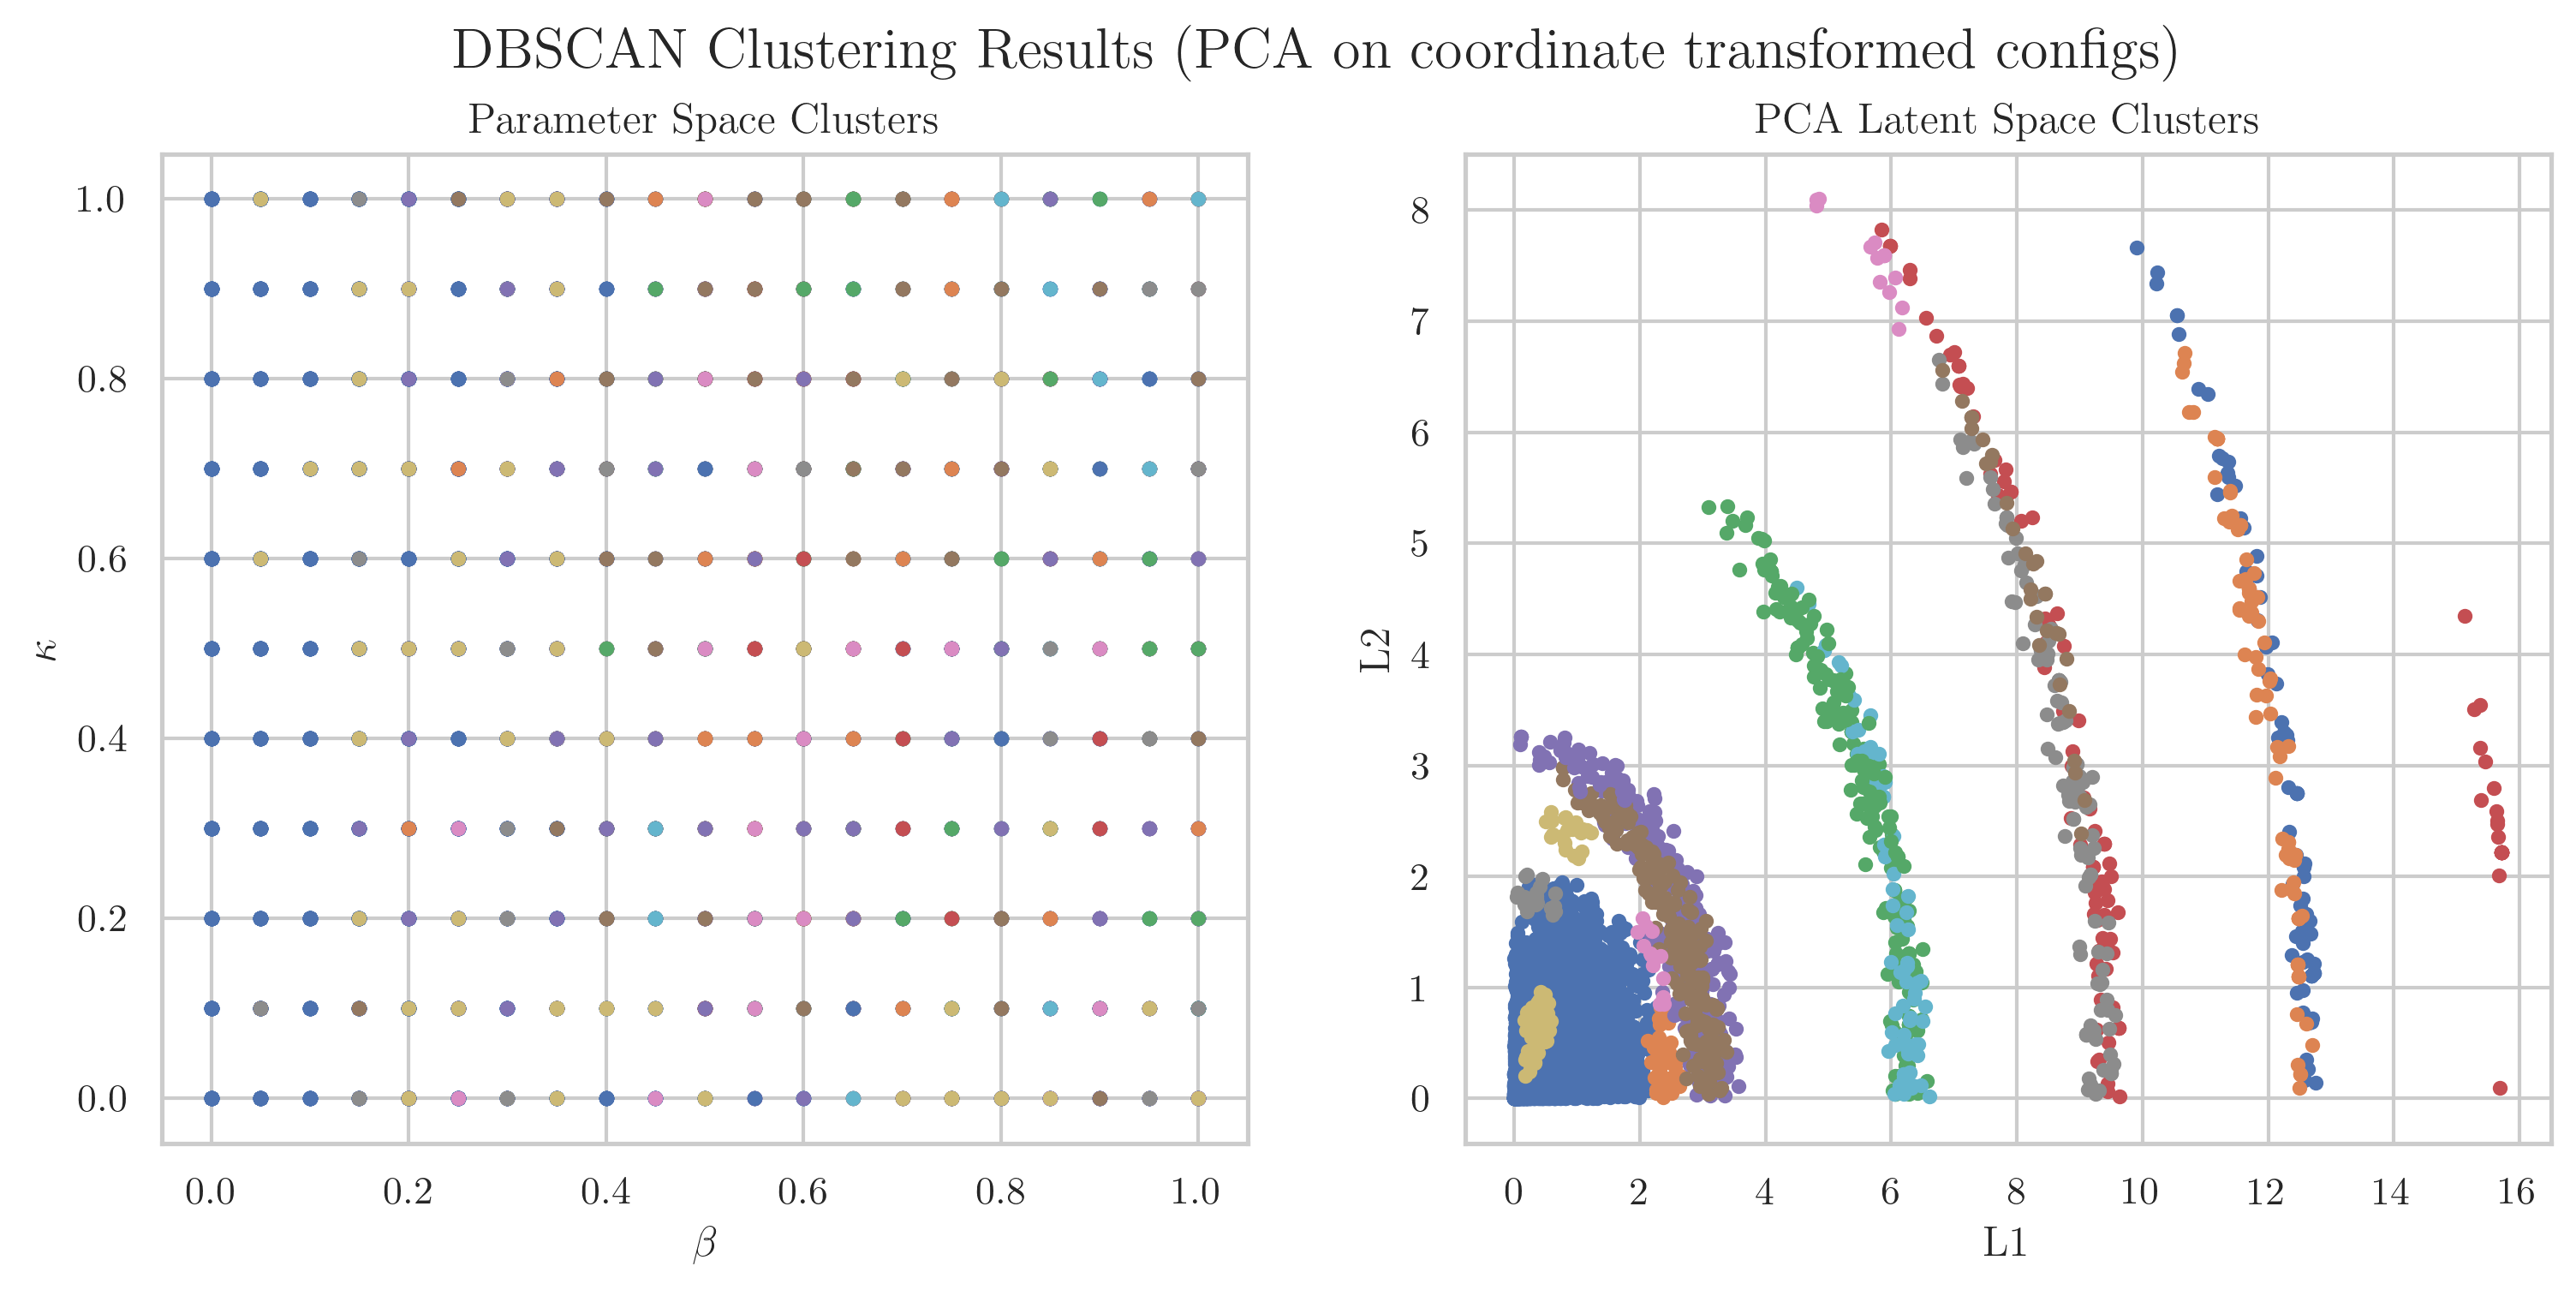

In [54]:
print(np.unique(labels2).size, "clusters found")

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
fig.suptitle('DBSCAN Clustering Results (PCA on coordinate transformed configs)', fontsize=16)
for cluster_id in np.unique(labels2):
    if cluster_id != -1:  # Exclude noise points
        cluster_points = params[labels2 == cluster_id]
        ax[0].scatter(cluster_points[:, 0],#+np.random.uniform(-.1,.1, size=cluster_points.shape[0]),
                      cluster_points[:, 1],#+np.random.uniform(-.075,.075, size=cluster_points.shape[0]),
                      s=10, label=f'Cluster {cluster_id}')

        cluster_points = latent_vectors[labels2 == cluster_id]
        L1 = cluster_points[:, 0]*np.cos(cluster_points[:, 1]); L2 = cluster_points[:, 0]*np.sin(cluster_points[:, 1])
        L1 = np.abs(L1); L2 = np.abs(L2)
        cluster_points = np.vstack((L1, L2)).T
        ax[1].scatter(cluster_points[:, 0], cluster_points[:, 1], s=10, label=f'Cluster {cluster_id}')
ax[0].set_title('Parameter Space Clusters')
ax[0].set_ylabel(r'$\kappa$')
ax[0].set_xlabel(r'$\beta$')
ax[1].set_title('PCA Latent Space Clusters')
ax[1].set_xlabel('L1')
ax[1].set_ylabel('L2')
plt.show()

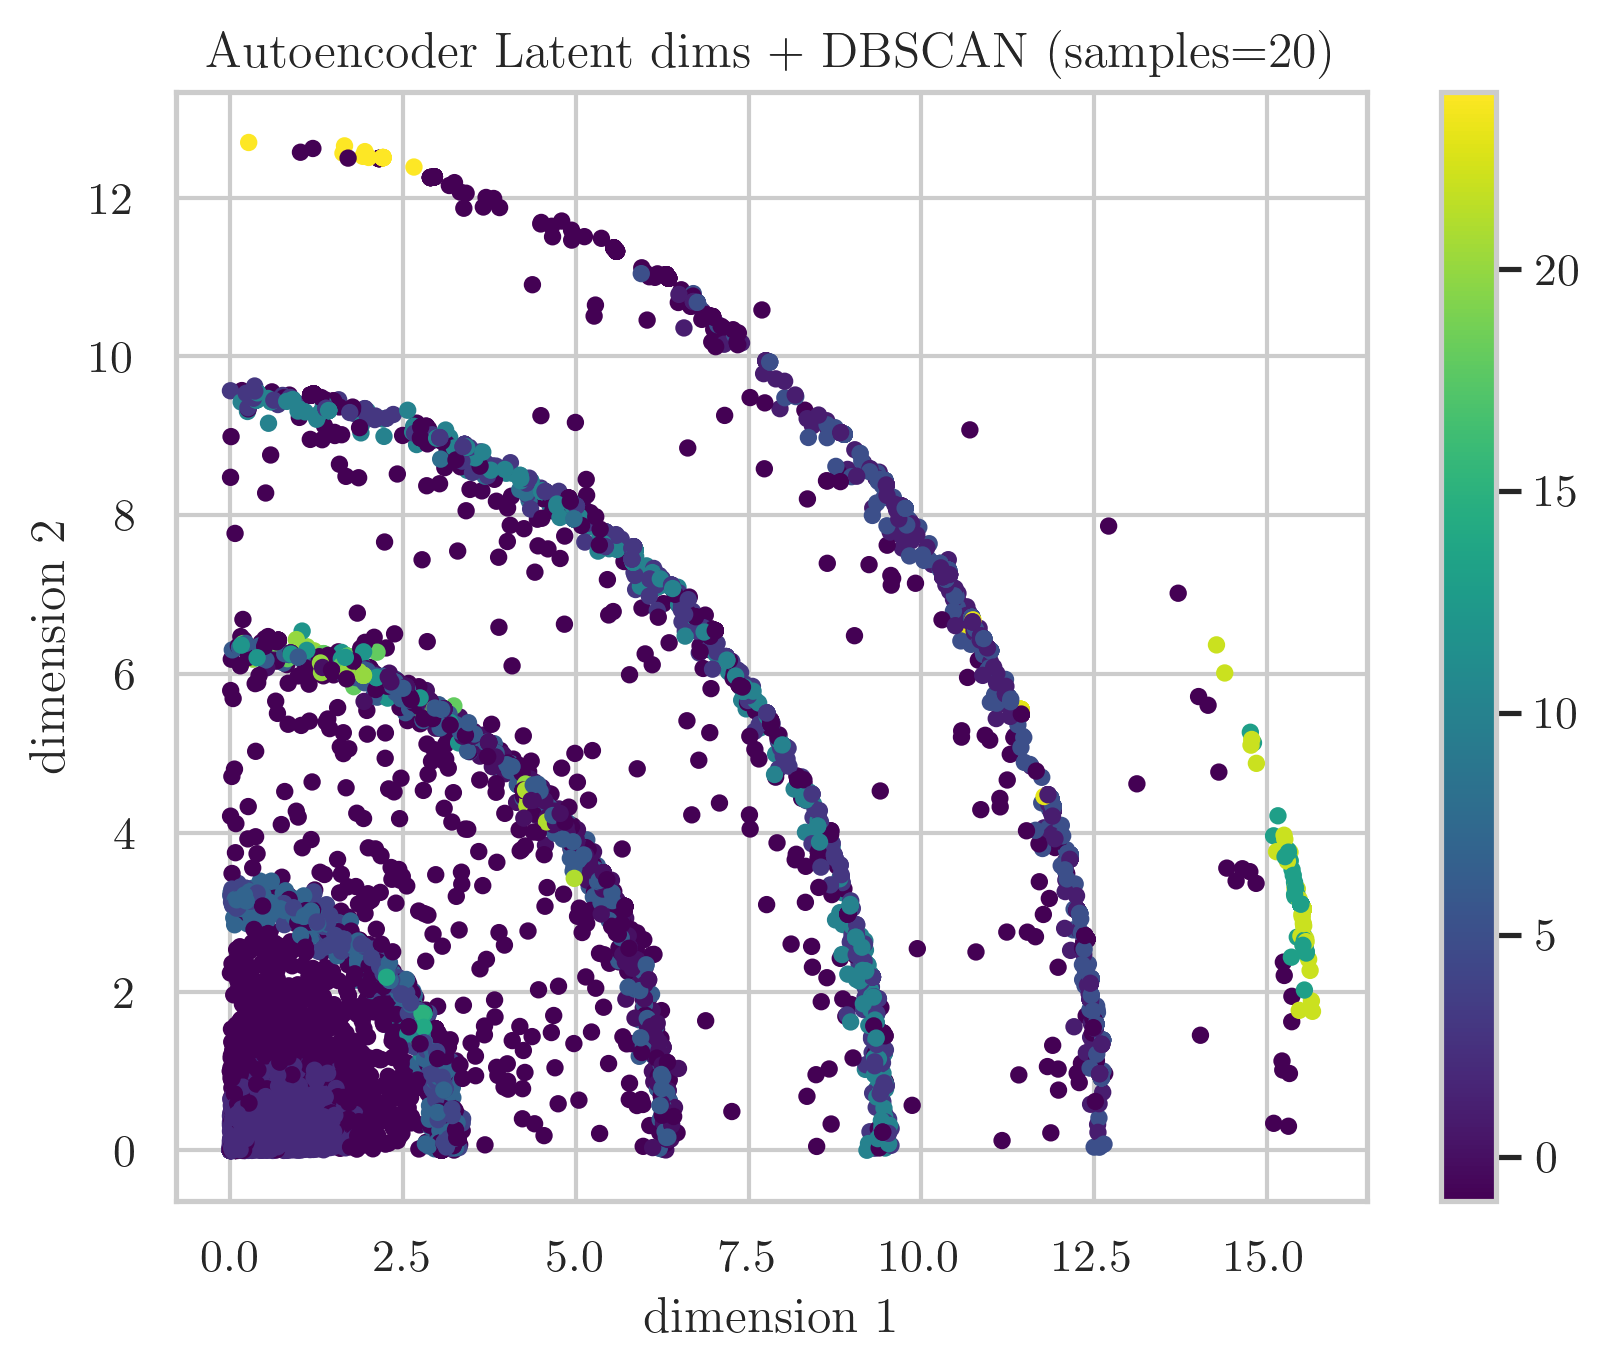

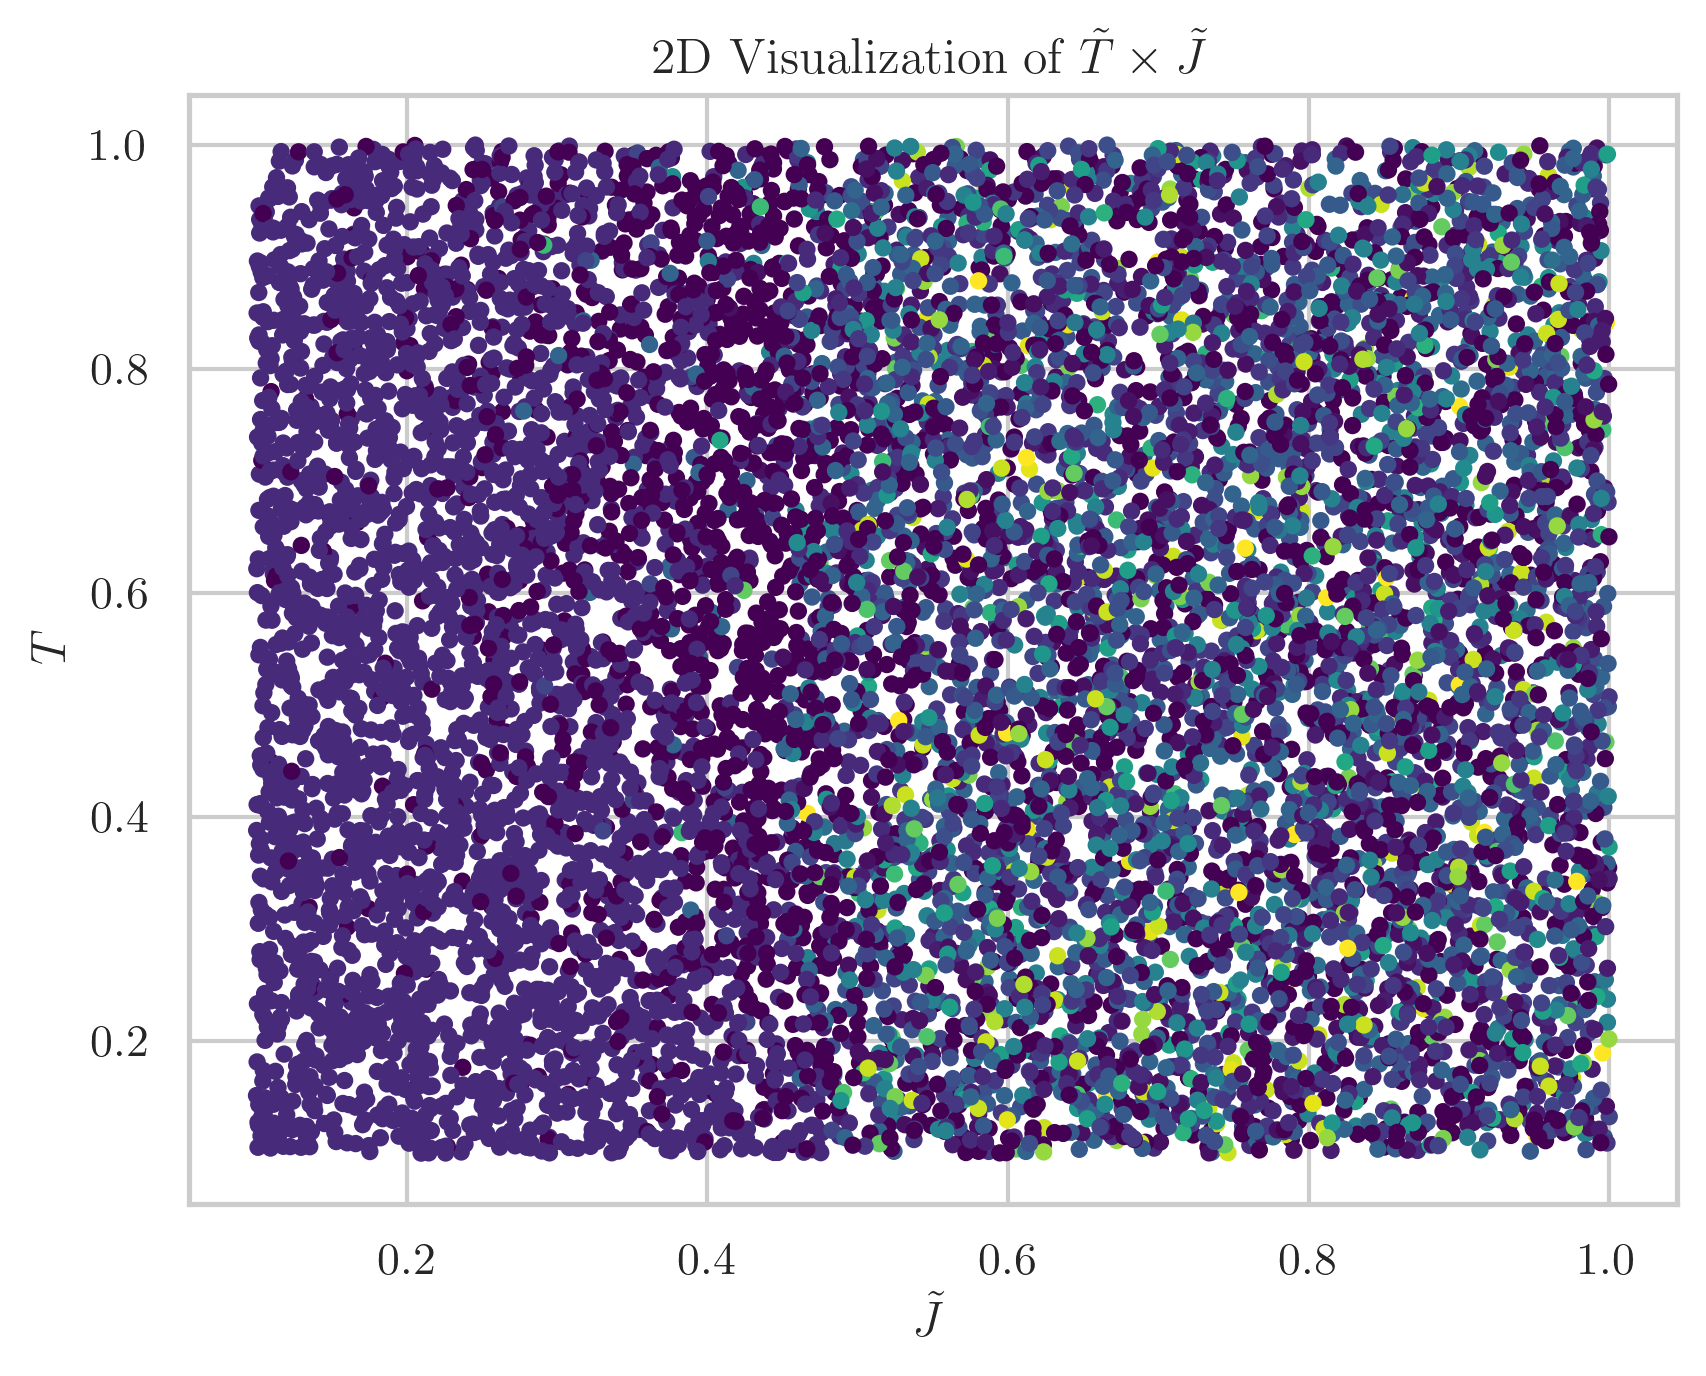

In [11]:
scatter2 = plt.scatter(L1, L2, c=labels2, cmap='viridis', s=10)
plt.colorbar(scatter2)
plt.title("Autoencoder Latent dims + DBSCAN (samples="+str(min_samples)+")")
plt.xlabel('dimension 1')
plt.ylabel('dimension 2')
# plt.legend()
plt.show()


plt.scatter(params[:, 0], params[:,1], c=labels2, cmap='viridis', s=10)
# plt.colorbar(scatter, ticks=range(10), label='PCA of Latent Space')
plt.title(r'2D Visualization of $\tilde{T} \times \tilde{J}$')
plt.xlabel(r'$\tilde{J}$')
plt.ylabel(r'$T$')
# if saving: plt.savefig(data_dir + "checkpoints/Autoencoder/"+date+"/phases.png", bbox_inches='tight')
plt.show()


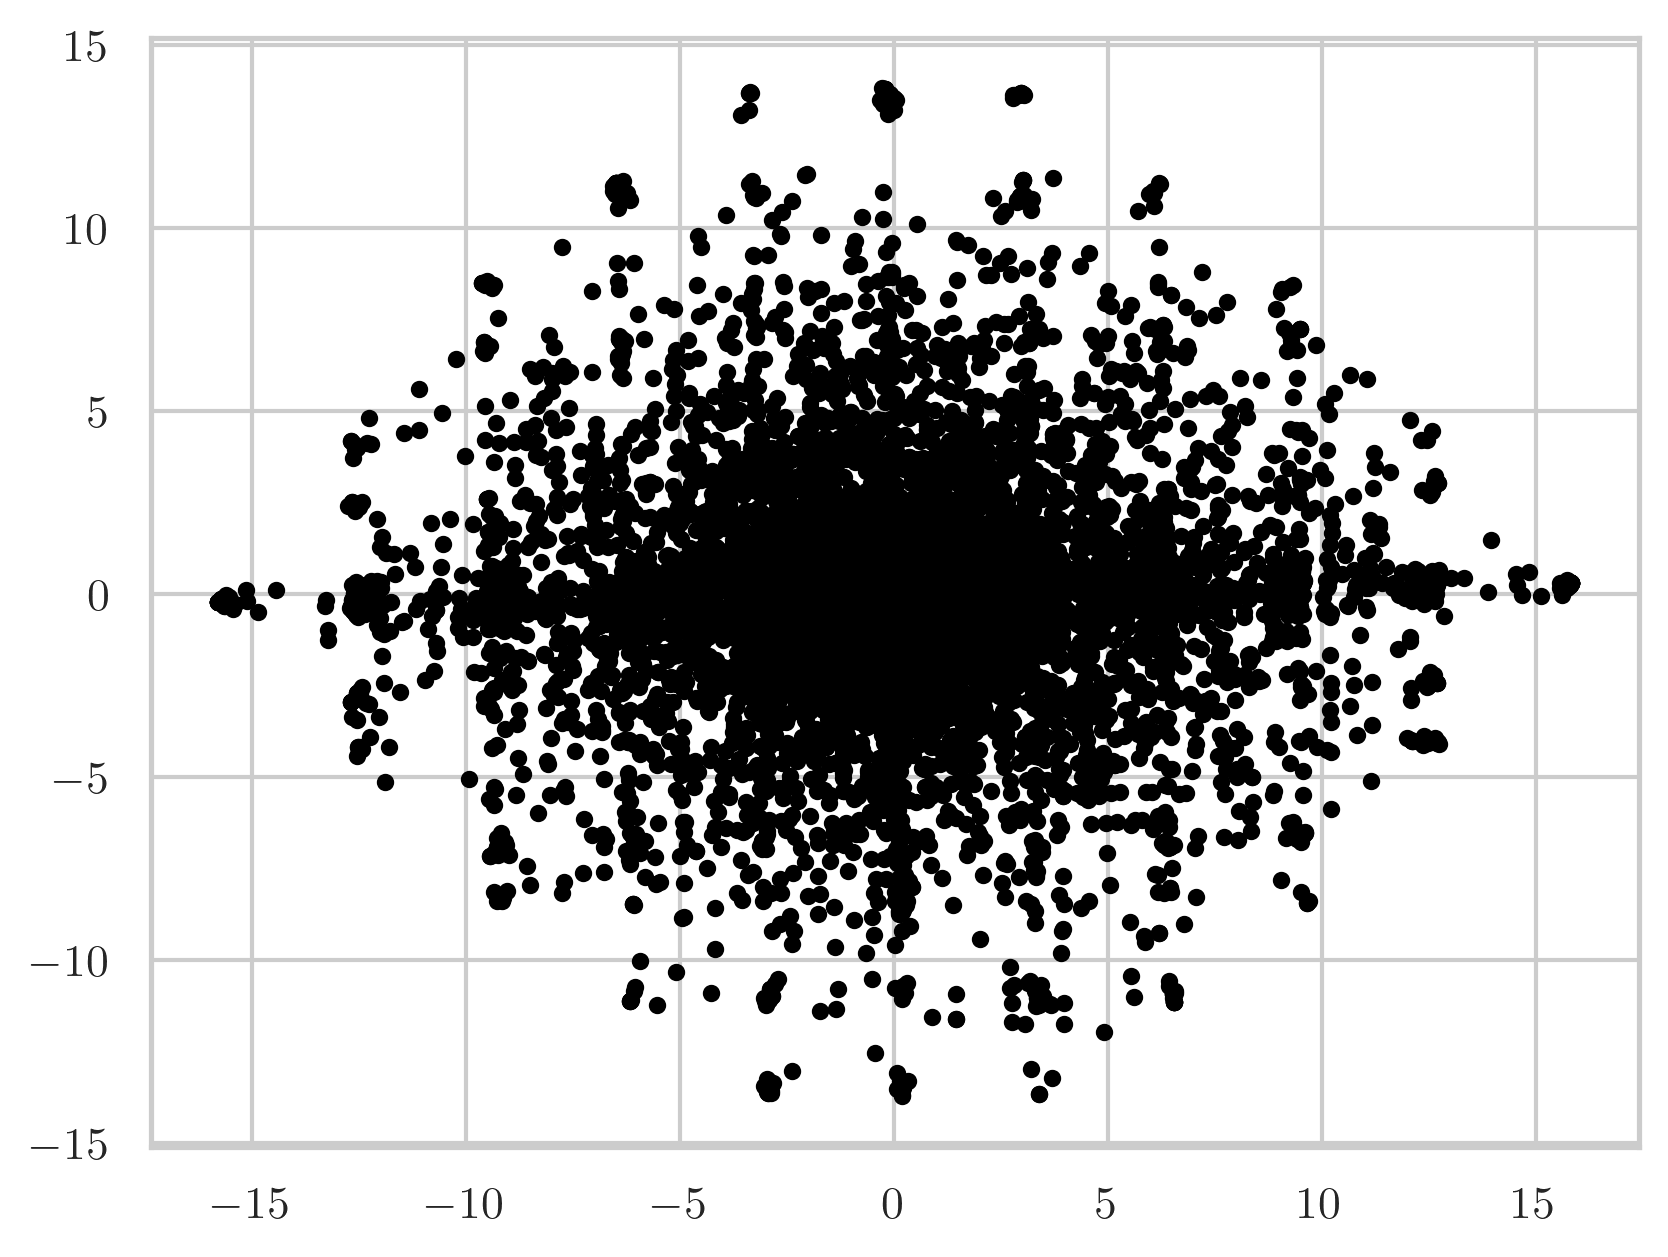

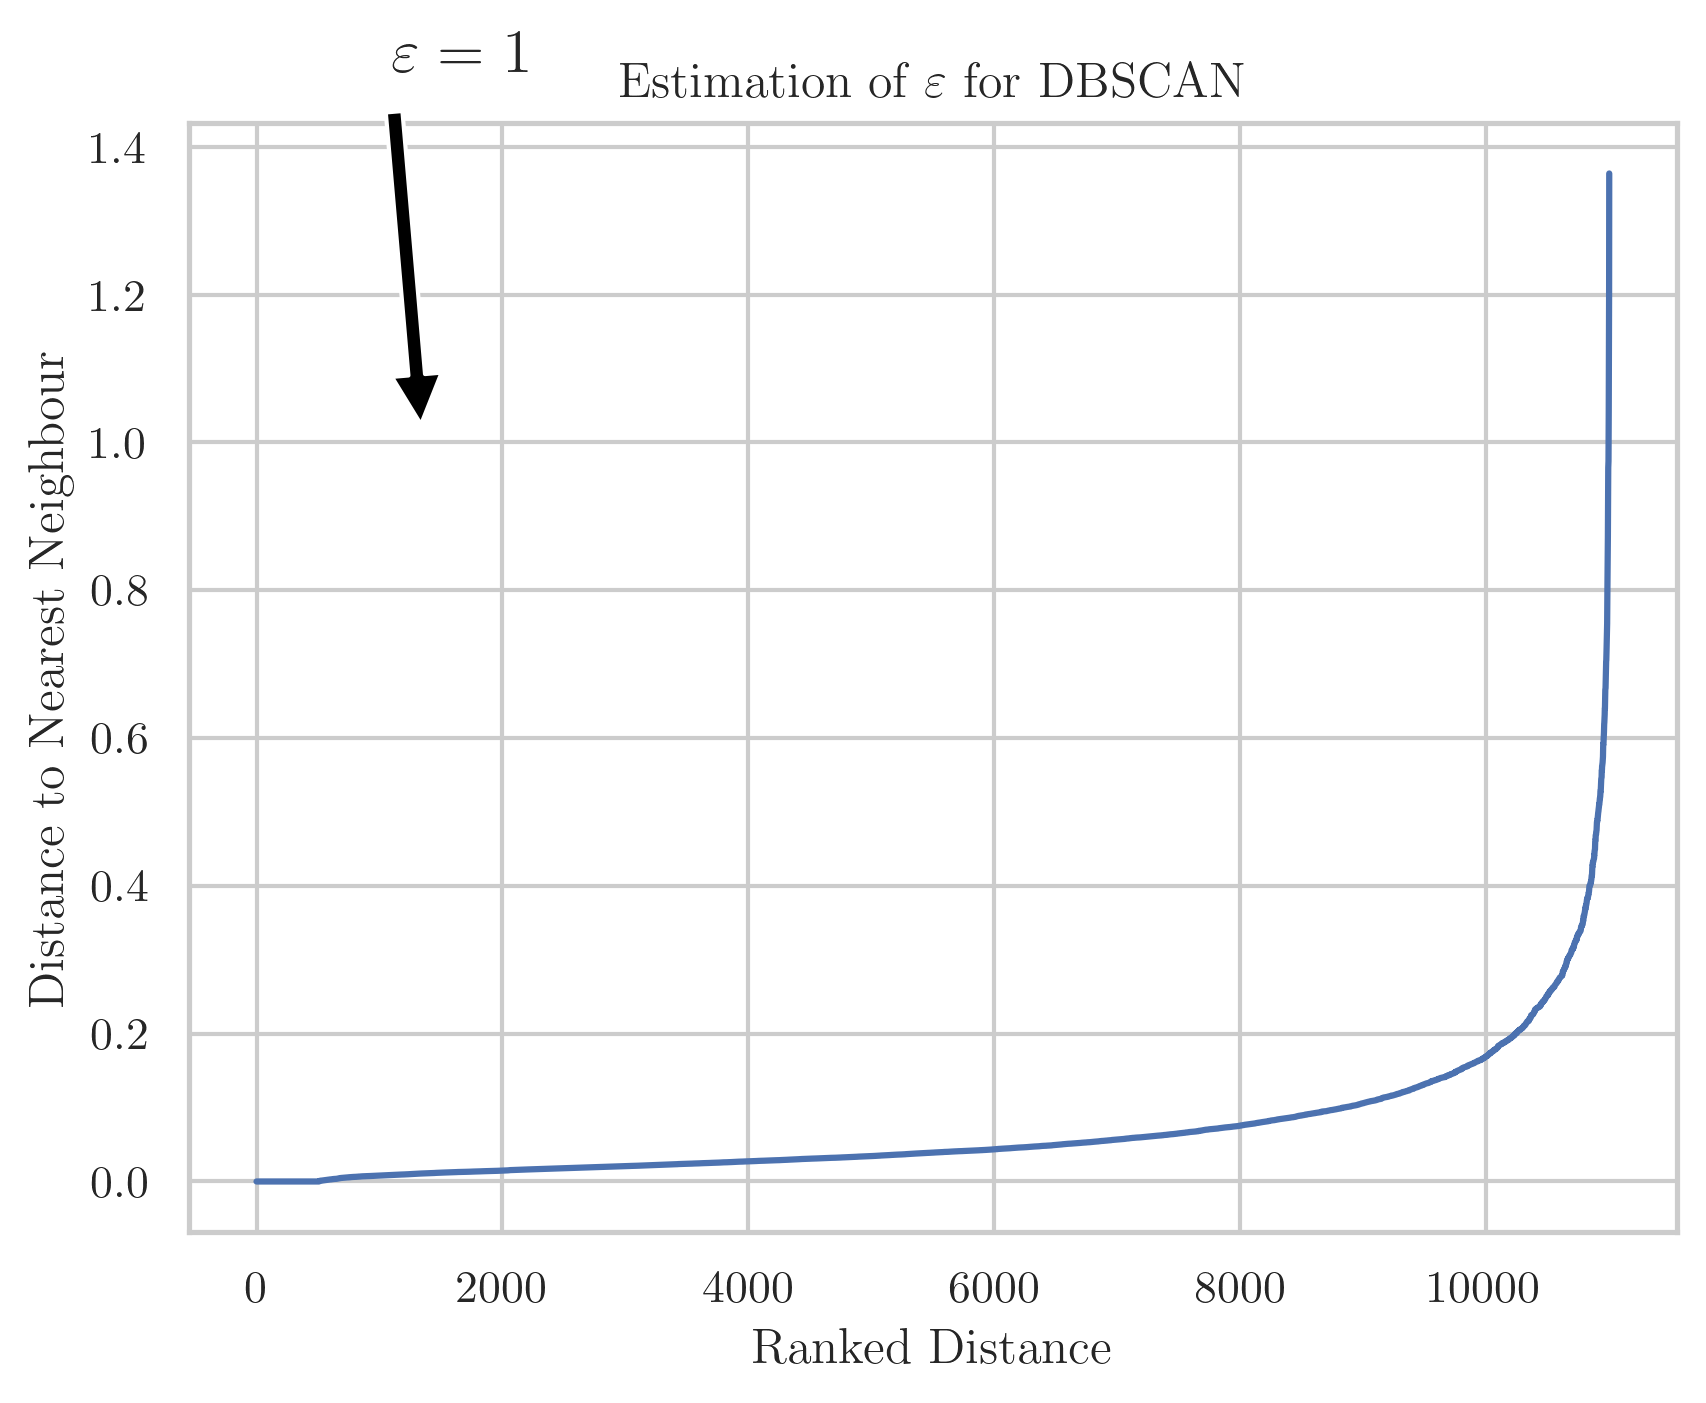

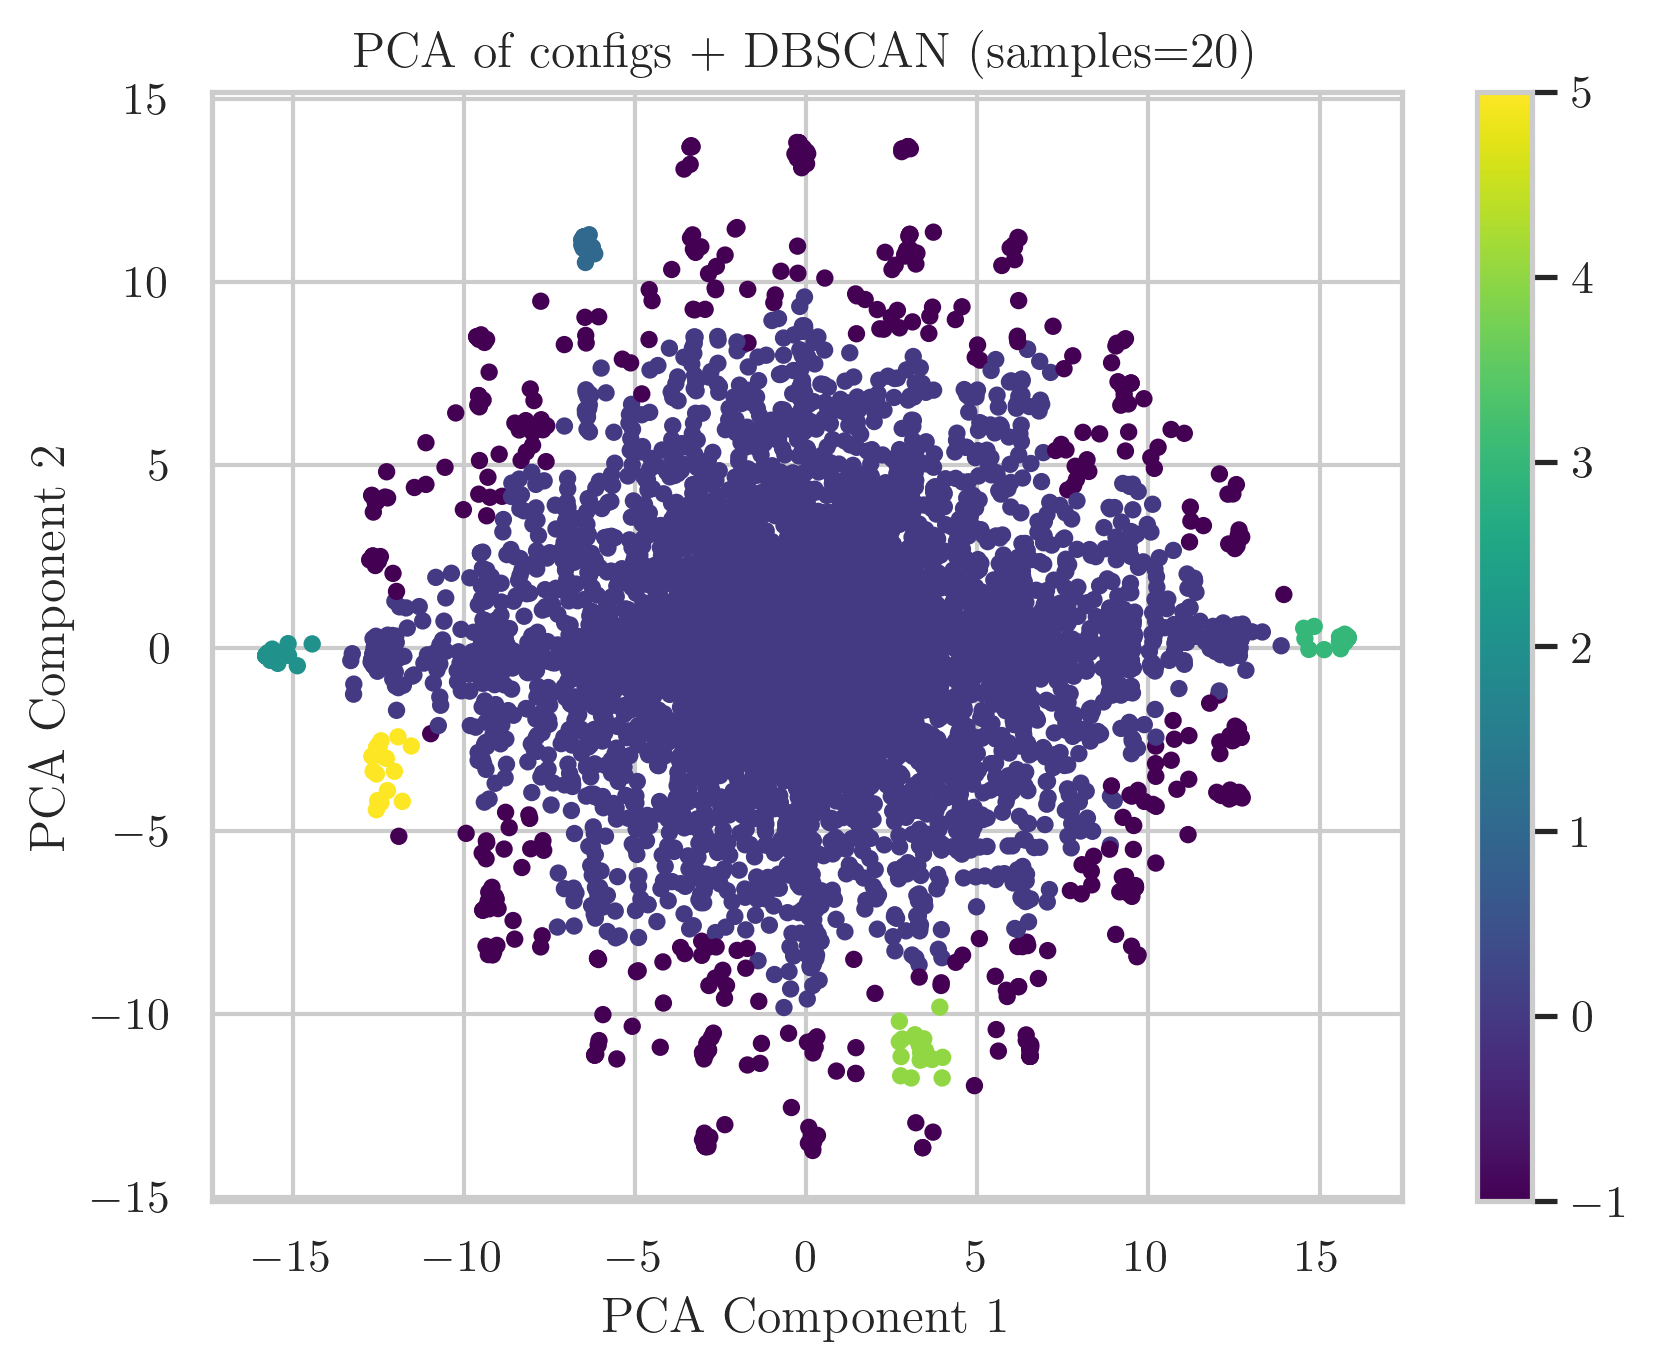

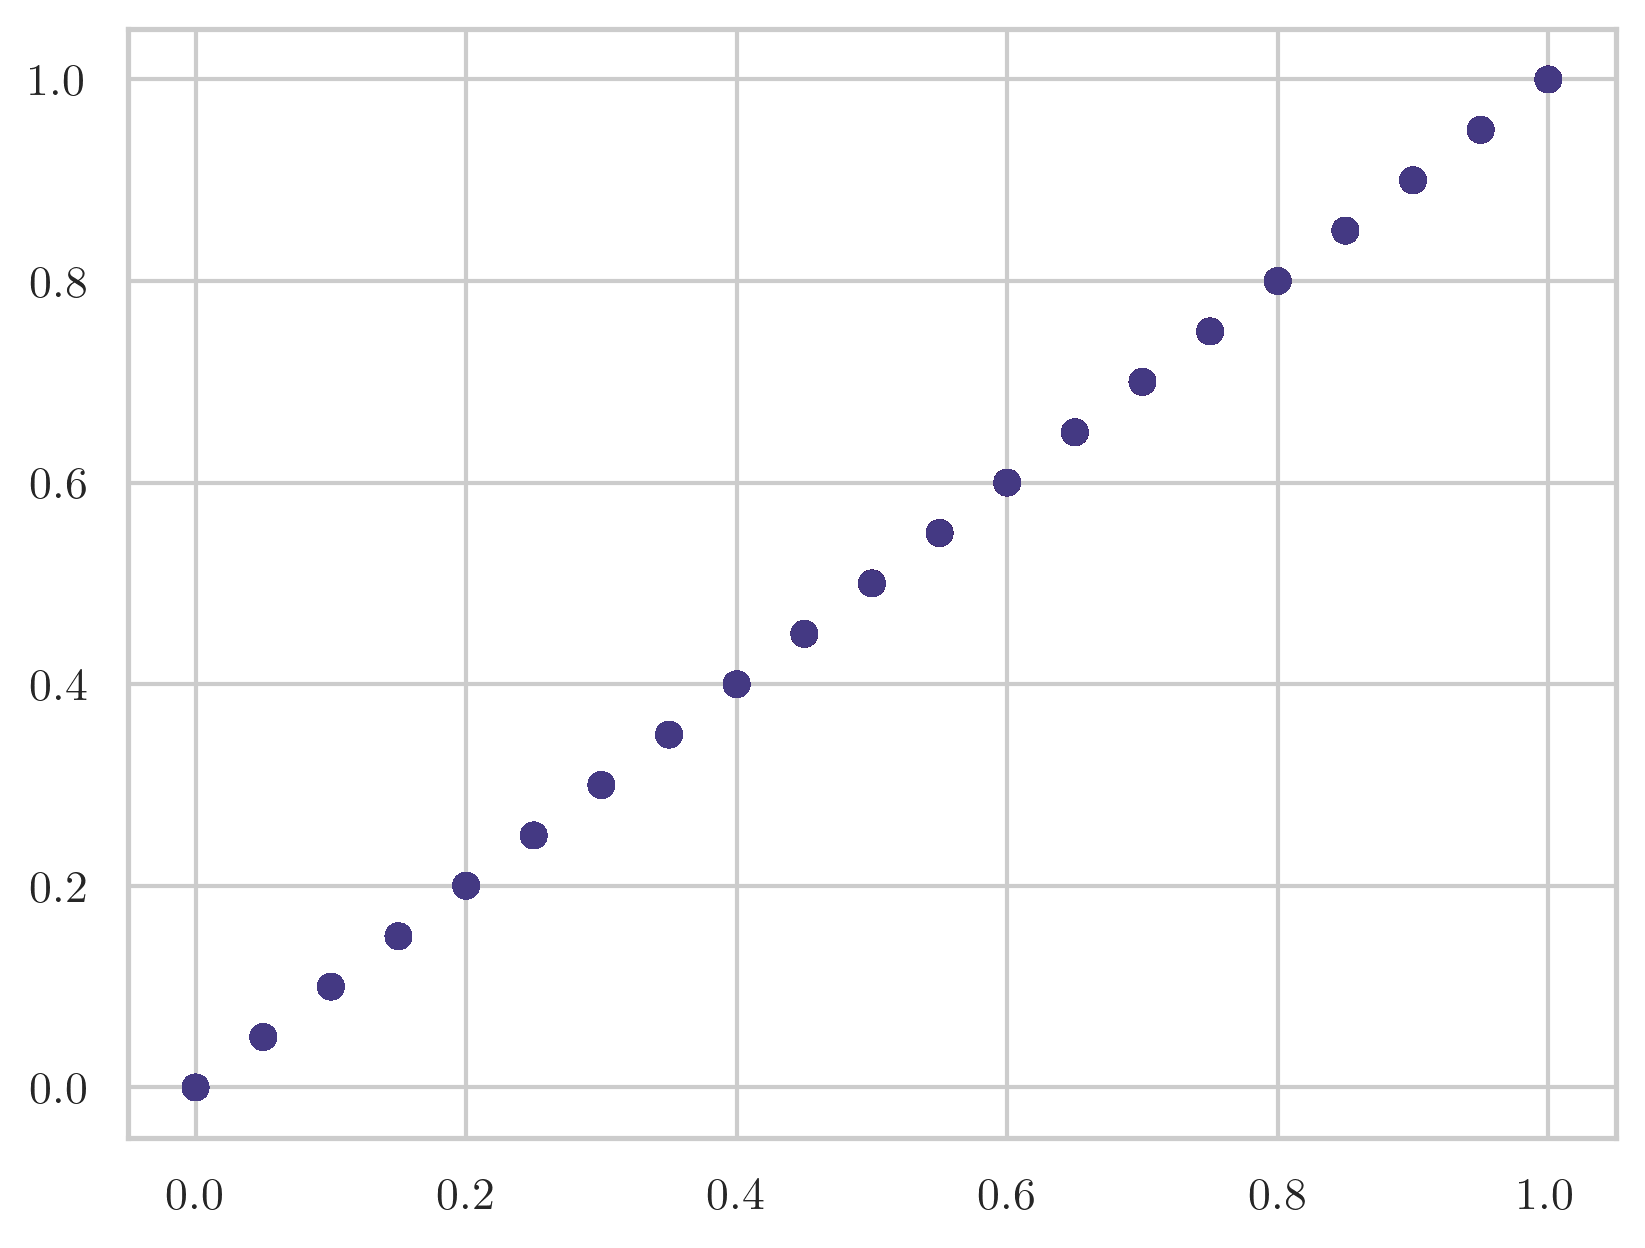

In [ ]:
# coordinate transformation
L1 = np.abs(latent_vectors[:, 0]); L2 = np.abs(latent_vectors[:, 1])
aeTrans = np.column_stack((L1, L2))

plt.scatter(L1, L2, s=10, c='black')
plt.title("Autoencoder Latent Space after Coordinate Transform")
plt.xlabel(r'$|x|$')
plt.ylabel(r'$|y|$')
# if saving: plt.savefig(data_dir + "checkpoints/Autoencoder/"+date+"/configs_Trans.png", bbox_inches='tight')
plt.show()

# neighbours = NearestNeighbors(n_neighbors=10)
neighbours_fit2 = neighbours.fit(aeTrans)
distances2,_ = neighbours_fit2.kneighbors(aeTrans)

distances2 = np.sort(distances2, axis=0)
distances2 = distances2[:, 1]  # Exclude the first column (distance to itself)



epsilon = 0.65
min_samples = 20
dbscan2 = DBSCAN(eps=epsilon, min_samples=min_samples)
labels2 = dbscan2.fit_predict(aeTrans)
plt.hlines(y=epsilon, xmin=0, xmax=np.max(np.where(distances2<epsilon)), color='red', linestyle='--', label=r'$\varepsilon$', linewidth=1)
plt.plot(distances2, label='Nearest Neighbours Distance')
plt.title(rf'Estimation of $\varepsilon$ for DBSCAN; $\varepsilon=${epsilon}')
plt.xlabel('Ranked Distance')
plt.ylabel('Distance to Nearest Neighbour')
# plt.ylim(0.0, 0.150)
# plt.xlim(3550, 4000)
# if saving: plt.savefig(data_dir + "checkpoints/Autoencoder/"+date+"/epsilon_Trans.png", bbox_inches='tight')
plt.show()

scatter2 = plt.scatter(L1, L2, c=labels2, cmap='viridis', s=10)
plt.colorbar(scatter2)
plt.title("Autoencoder Transformed Latent dims + DBSCAN (samples="+str(min_samples)+")")
plt.xlabel(r'$|x|$')
plt.ylabel(r'$|y|$')
# plt.legend()
# if saving: plt.savefig(data_dir + "checkpoints/Autoencoder/"+date+"/configs_Trans+DBSCAN.png", bbox_inches='tight')
plt.show()



plt.scatter(params[:, 0], params[:,1], c=labels2, cmap='viridis', s=30)
# plt.colorbar(scatter, ticks=range(10), label='PCA of Latent Space')
plt.title(r'2D Visualization of $\tilde{T} \times \tilde{J}$')
x = np.linspace(0, 3, 400)
plt.plot(-x*np.asinh(1/np.sinh(2/x))-1, x, '--', color='red')
plt.plot(x*np.asinh(1/np.sinh(2/x)) - 1, x, '--', color='red' )
plt.xlim(-3.1,1.1)
plt.xlabel(r'$\tilde{J}$')
plt.ylabel(r'$T$')
# if saving: plt.savefig(data_dir + "checkpoints/Autoencoder/"+date+"/phases.png", bbox_inches='tight')
plt.show()


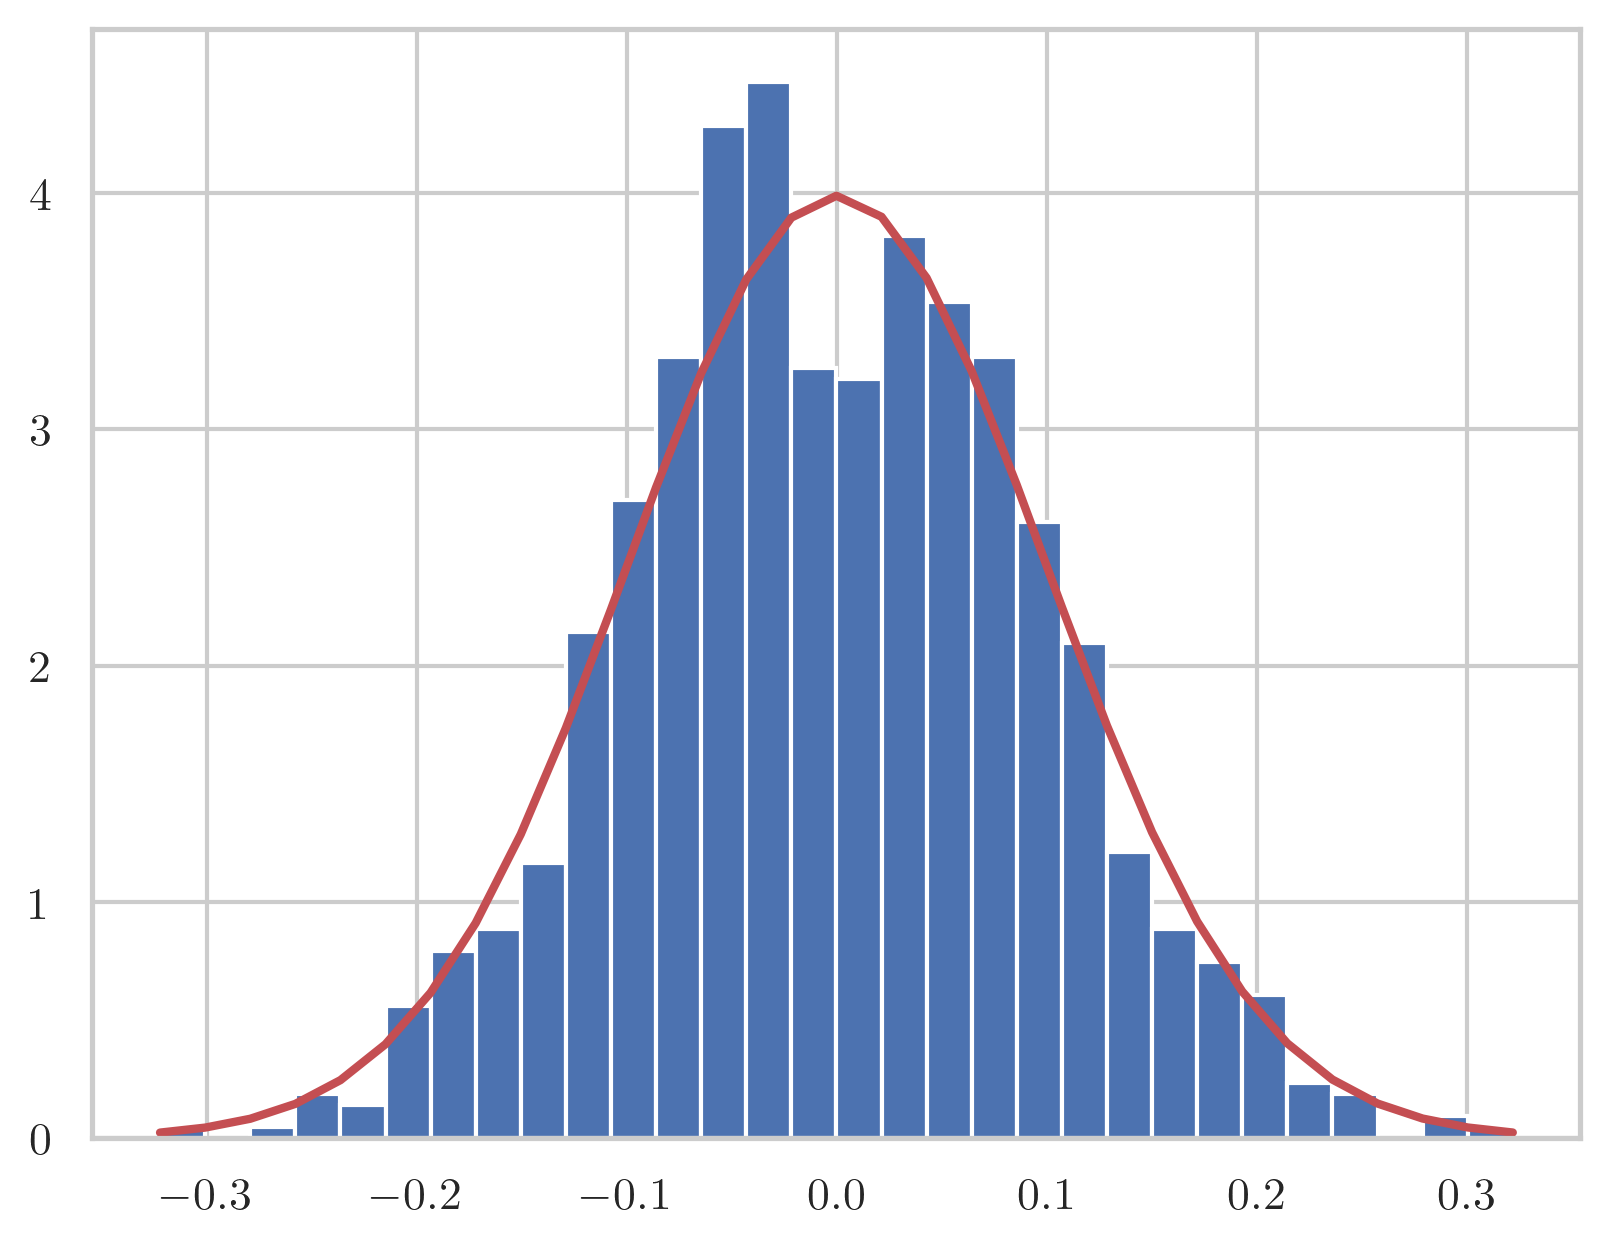

In [19]:
mu, sigma = 0, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
abs(mu - np.mean(s))
abs(sigma - np.std(s, ddof=1))

count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()